# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 7.74 s, sys: 644 ms, total: 8.39 s
Wall time: 7.83 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = 1
tpu_cores = None
precision=32

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [6]:
torch.cuda.is_available()

True

# Here goes all the stuff that we change from dataset to dataset

In [7]:
from os import path

In [8]:
dataset_dir = '../data/zeisel/'
model_save_path = '../data/zeisel/models/'
viz_save_path = '../data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [9]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [10]:
adata.obs

names0 names1 labels0 labels1
0          interneurons  Int10       3      12
1          interneurons  Int10       3      12
2          interneurons   Int6       3      23
3          interneurons  Int10       3      12
4          interneurons   Int9       3      26
...                 ...    ...     ...     ...
3000  endothelial-mural  Peric       2      35
3001  endothelial-mural   Vsmc       2      48
3002  endothelial-mural   Vsmc       2      48
3003  endothelial-mural   Vsmc       2      48
3004  endothelial-mural   Vsmc       2      48

[3005 rows x 4 columns]

In [11]:
adata.shape

(3005, 4000)

In [12]:
np.apply_along_axis(np.mean, 0, adata.X)

array([5.07780e-09, 4.06224e-08, 0.00000e+00, ..., 4.06224e-08,
       3.04668e-08, 0.00000e+00], dtype=float32)

In [13]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.9996673, 0.9996672, 0.9996674, ..., 0.9996672, 0.9996674,
       0.9996673], dtype=float32)

In [14]:
X = adata.X.copy()
adata.obs['names']=adata.obs['names0']
adata.obs['annotation'] = adata.obs['names0']
labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [15]:
input_size = X.shape[1]
y

array([2, 2, 2, ..., 1, 1, 1])

# Set Up Models

## Baseline

In [16]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

CPU times: user 4min 38s, sys: 4.62 s, total: 4min 42s
Wall time: 3min 1s


## Train Smash Random Forest





In [17]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

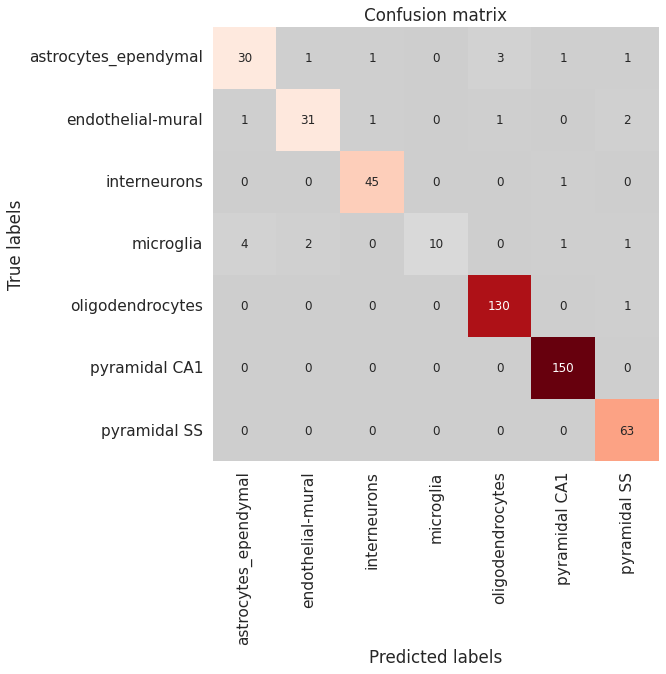

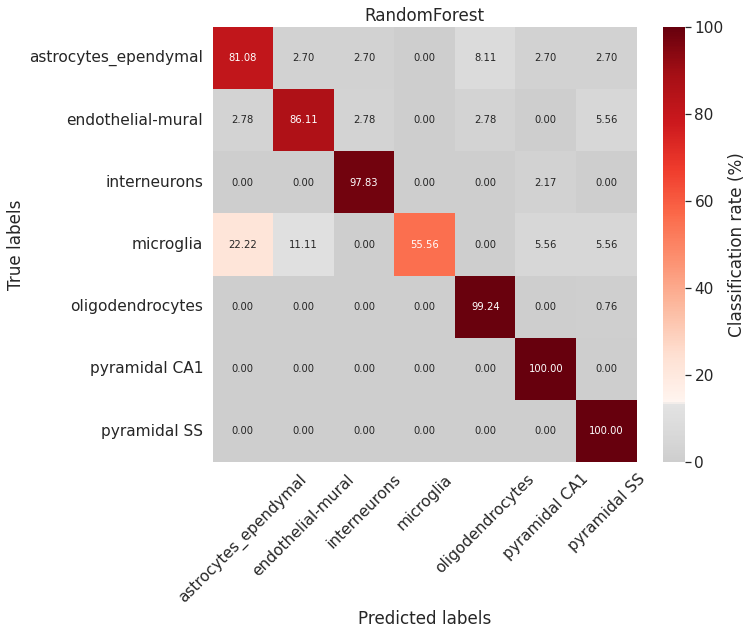

Accuracy: 0.9542619542619543: Misclassification: 0.04573804573804574
                      precision    recall  f1-score   support

astrocytes_ependymal       0.86      0.81      0.83        37
   endothelial-mural       0.91      0.86      0.89        36
        interneurons       0.96      0.98      0.97        46
           microglia       1.00      0.56      0.71        18
    oligodendrocytes       0.97      0.99      0.98       131
       pyramidal CA1       0.98      1.00      0.99       150
        pyramidal SS       0.93      1.00      0.96        63

            accuracy                           0.95       481
           macro avg       0.94      0.89      0.90       481
        weighted avg       0.95      0.95      0.95       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

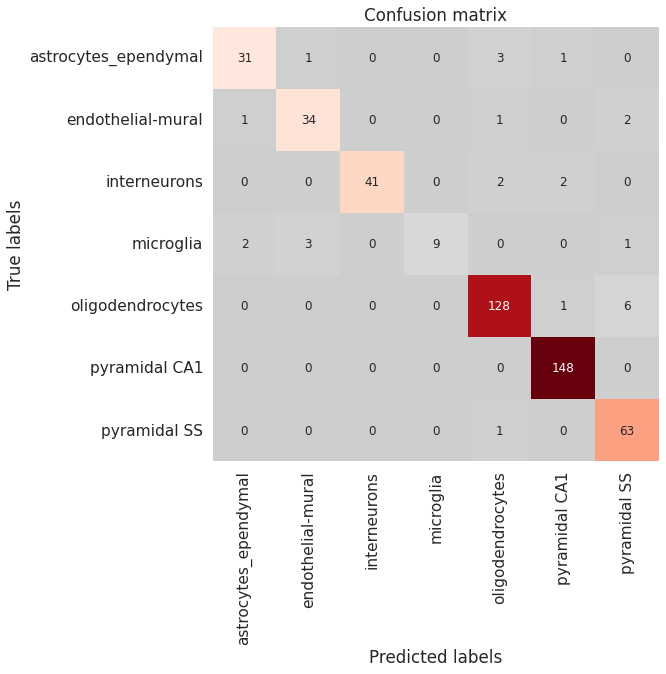

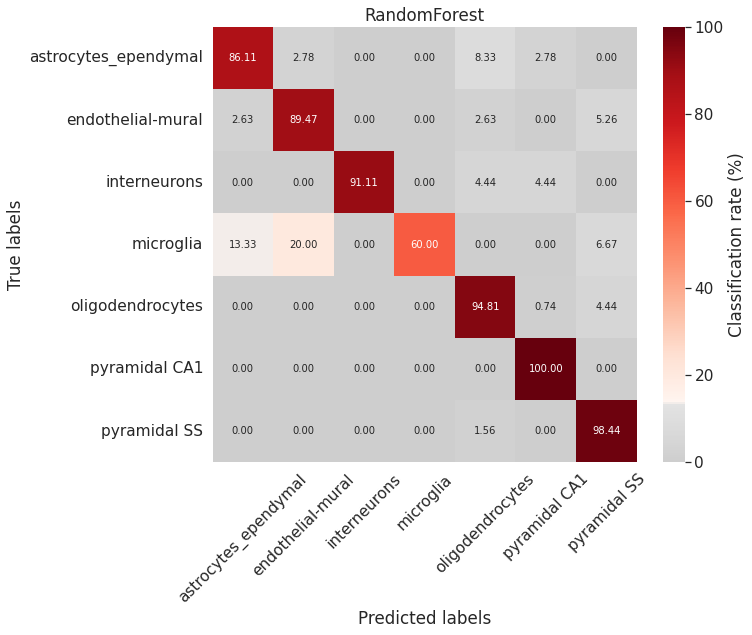

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

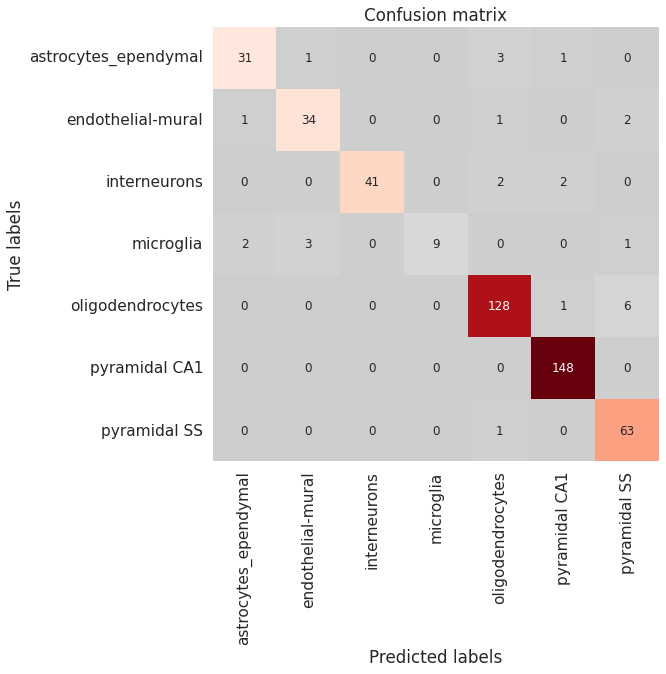

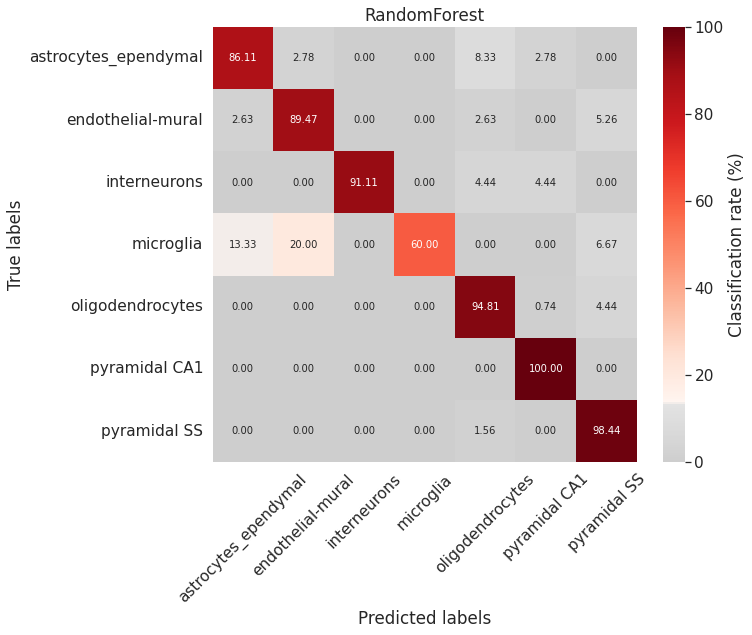

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

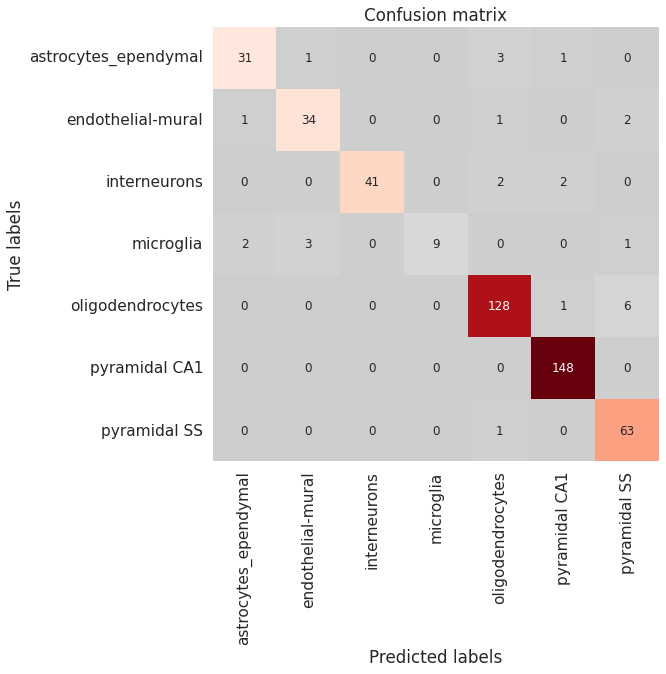

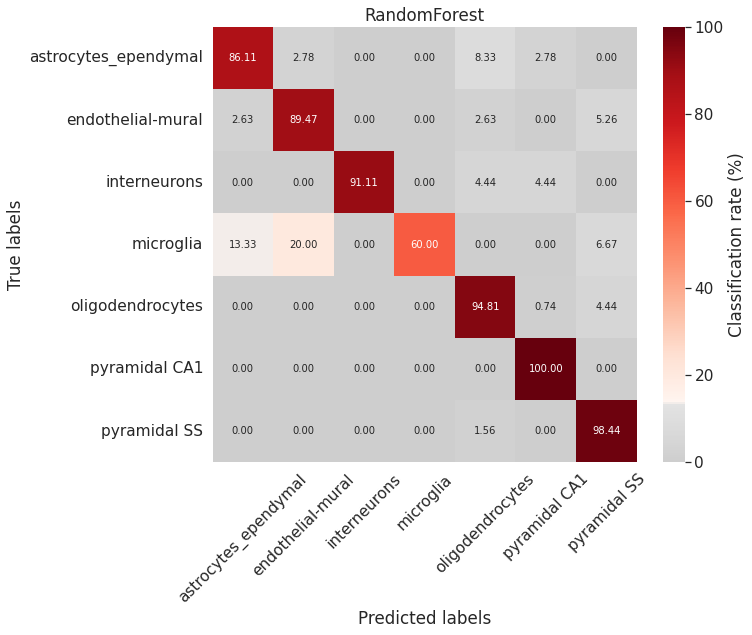

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

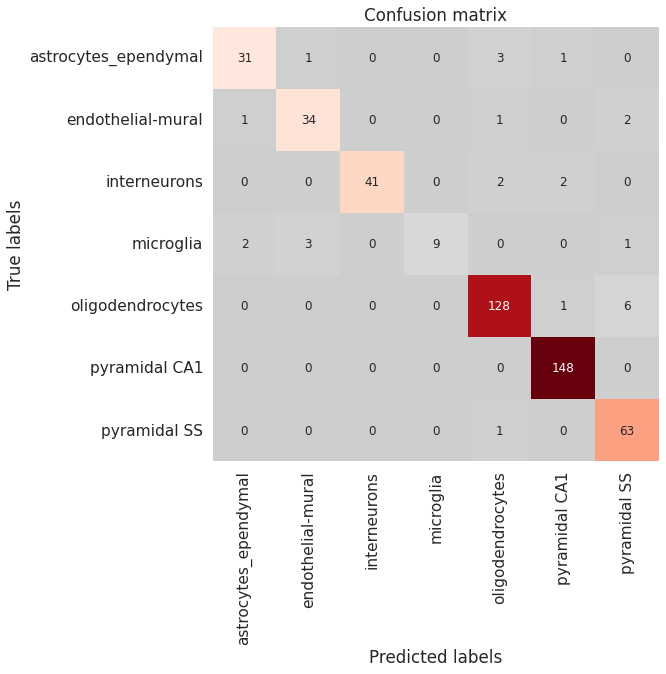

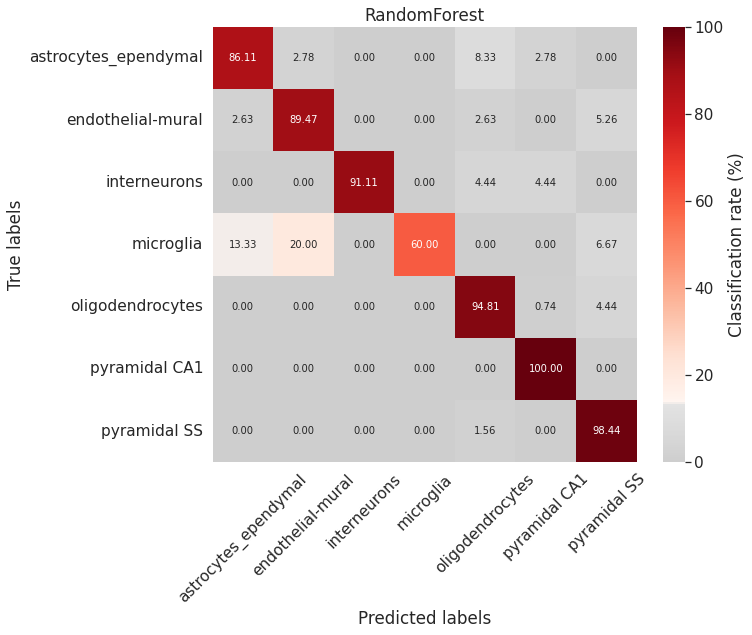

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

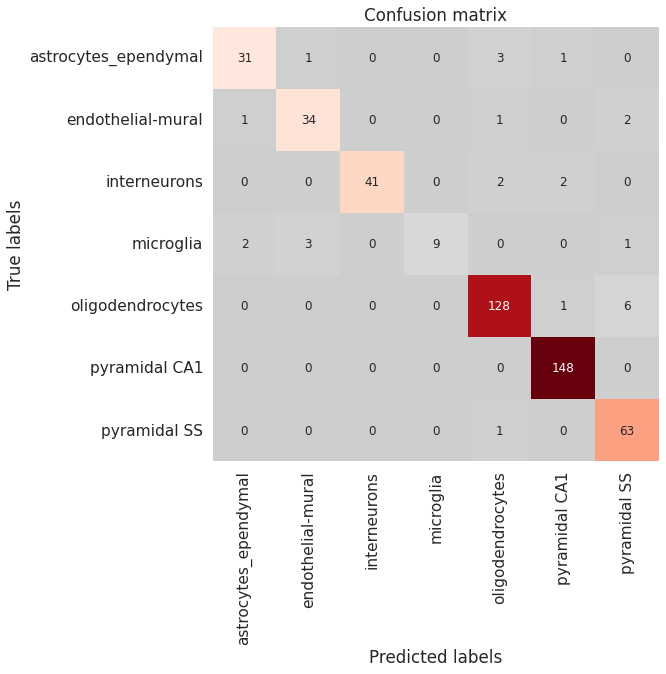

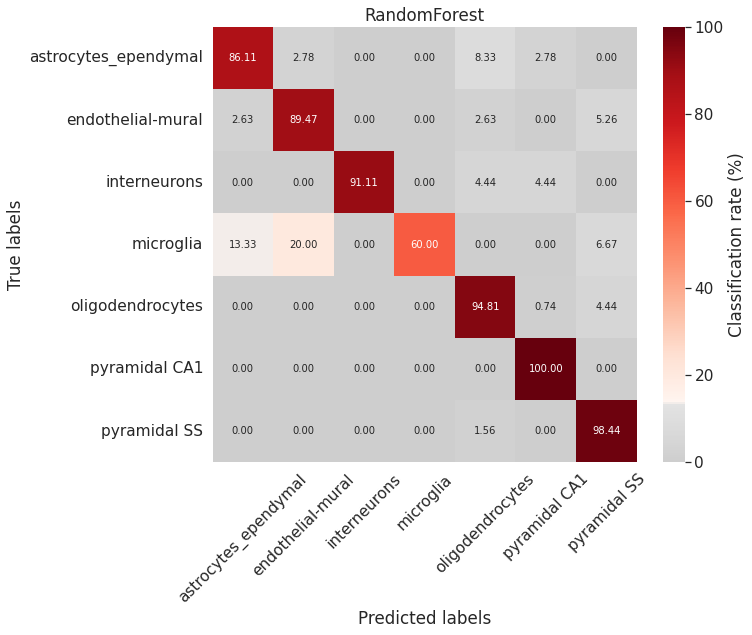

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

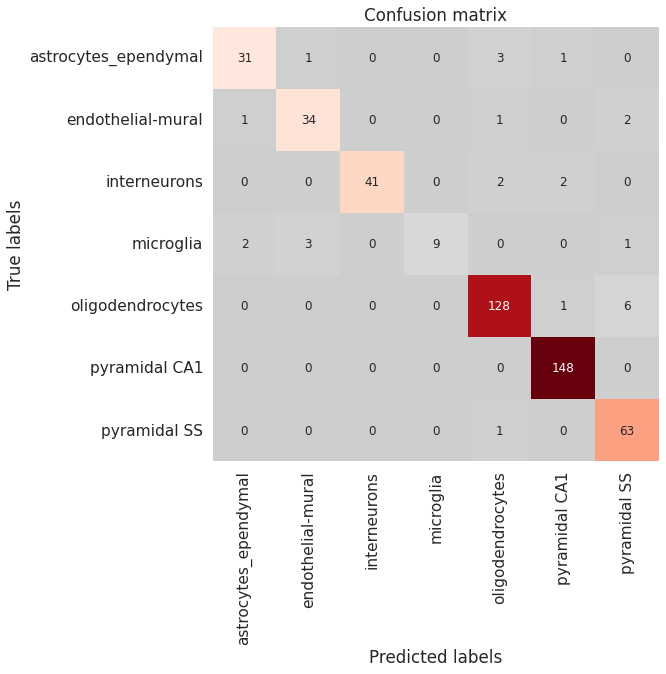

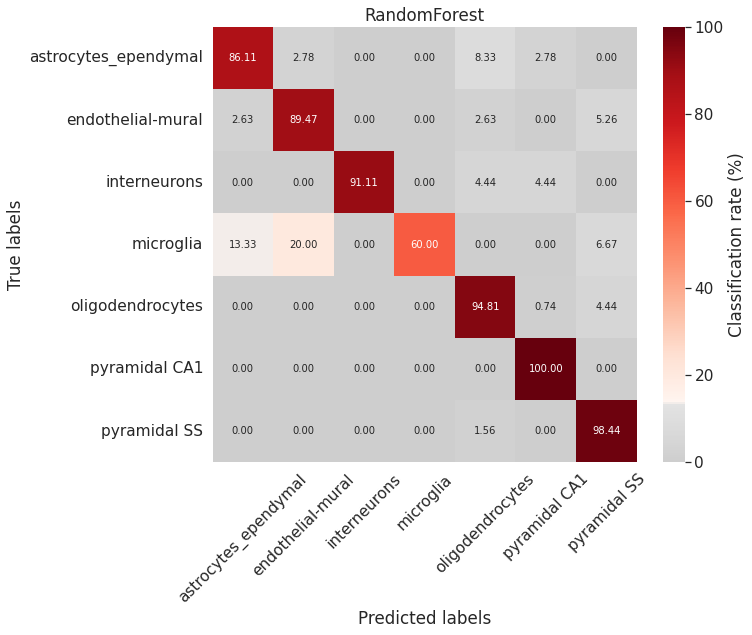

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

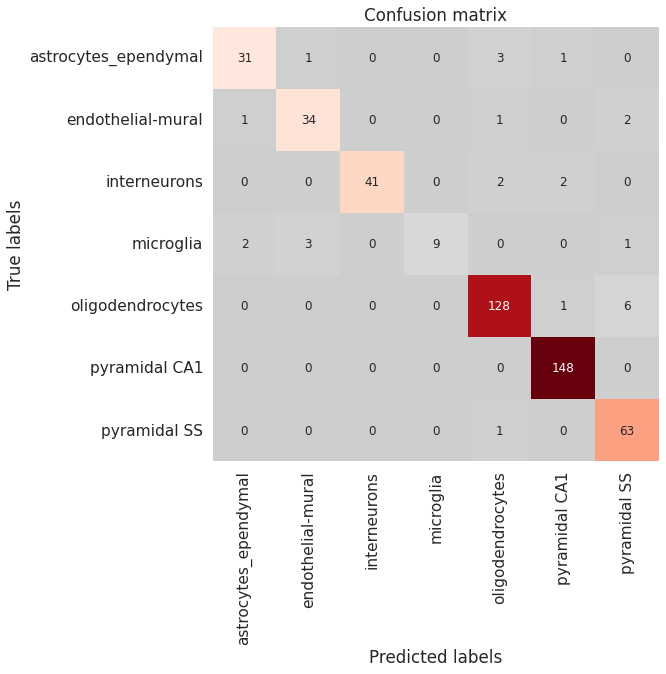

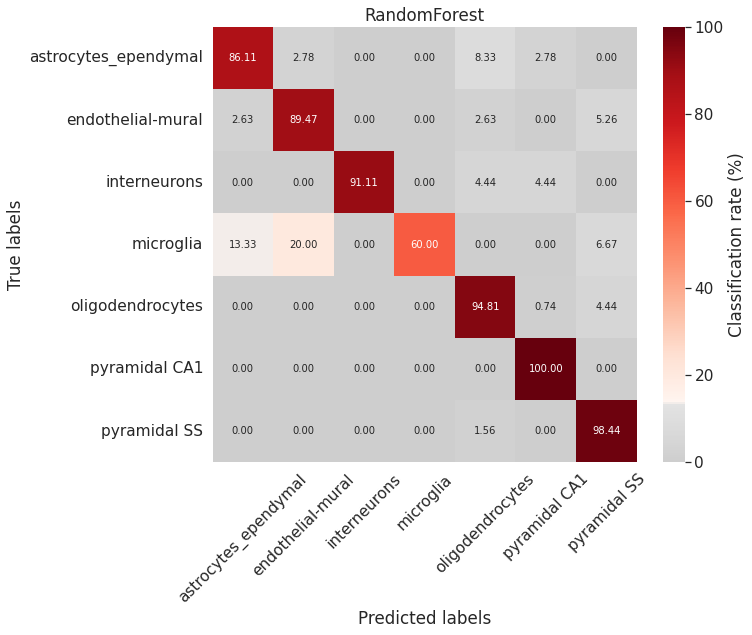

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

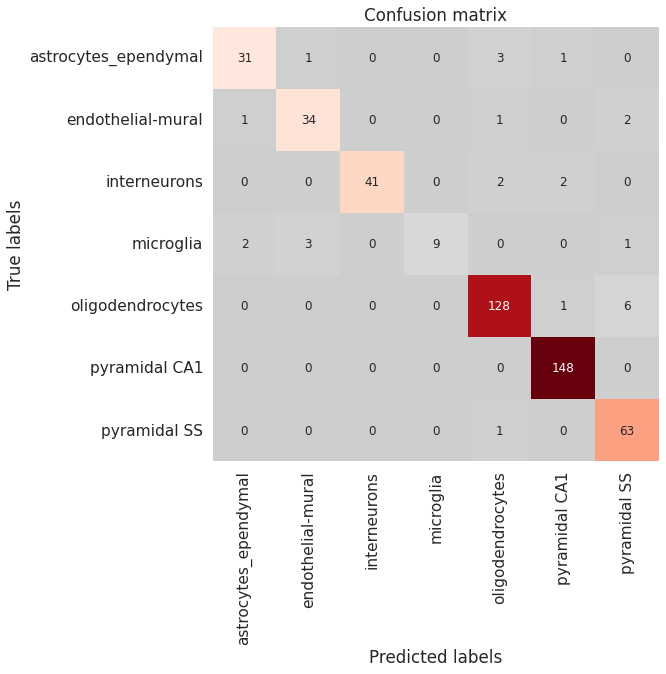

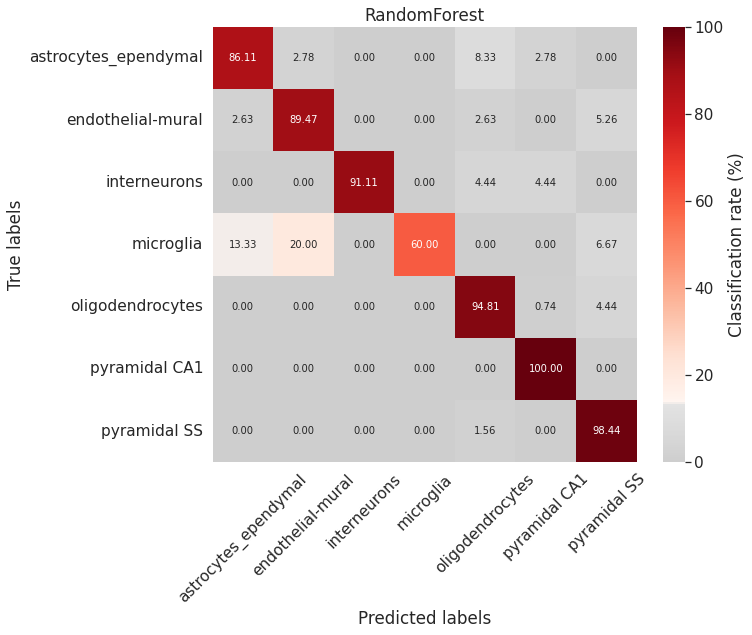

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

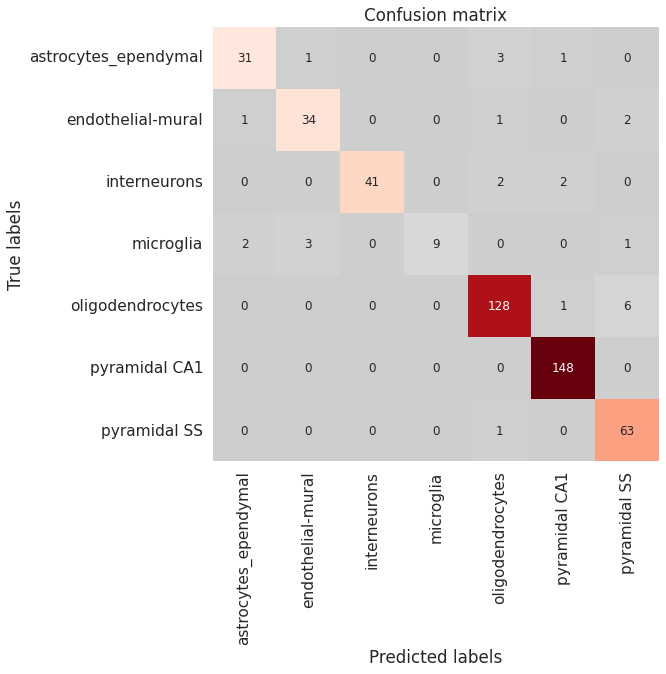

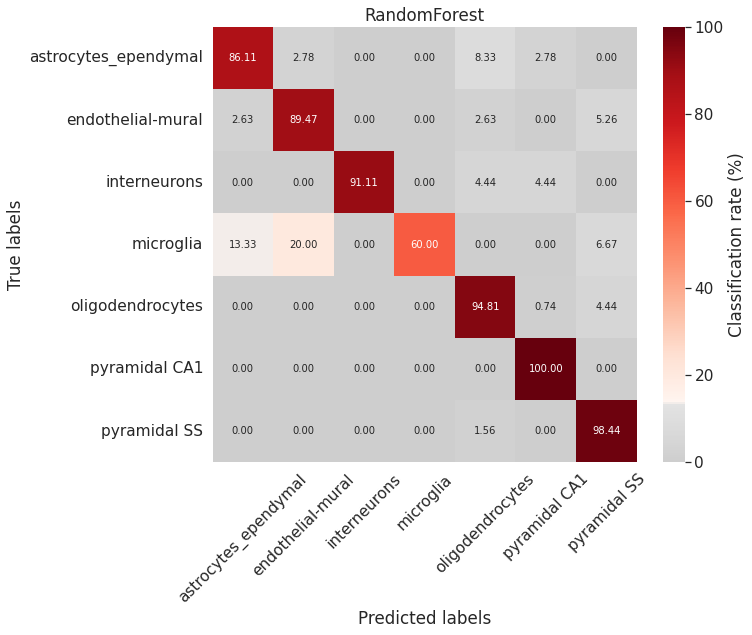

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 3min 33s, sys: 6.66 s, total: 3min 40s
Wall time: 2min 5s


In [18]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

25/25 [==============================] - 0s 4ms/step - loss: 0.2728 - accuracy: 0.9663 - auc: 0.9991 - precision: 0.9923 - recall: 0.9072 - val_loss: 0.3307 - val_accuracy: 0.9451 - val_auc: 0.9957 - val_precision: 0.9750 - val_recall: 0.9101

Epoch 00041: val_loss improved from 0.34421 to 0.33067, saving model to weights/best_model_annotation.h5
Epoch 42/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not im


Epoch 00065: val_loss improved from 0.20958 to 0.20130, saving model to weights/best_model_annotation.h5
Epoch 66/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1236 - accuracy: 0.9900 - auc: 0.9998 - precision: 0.9953 - recall: 0.9763 - val_loss: 0.2105 - val_accuracy: 0.9501 - val_auc: 0.9968 - val_precision: 0.9656 - val_recall: 0.9351

Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss

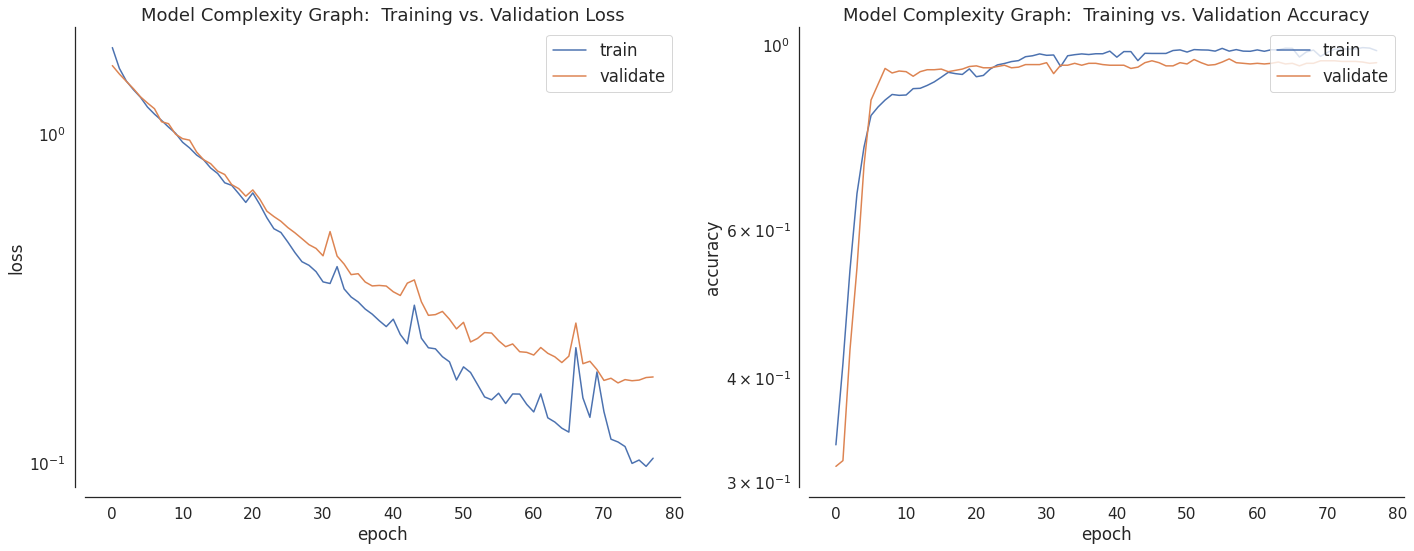

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

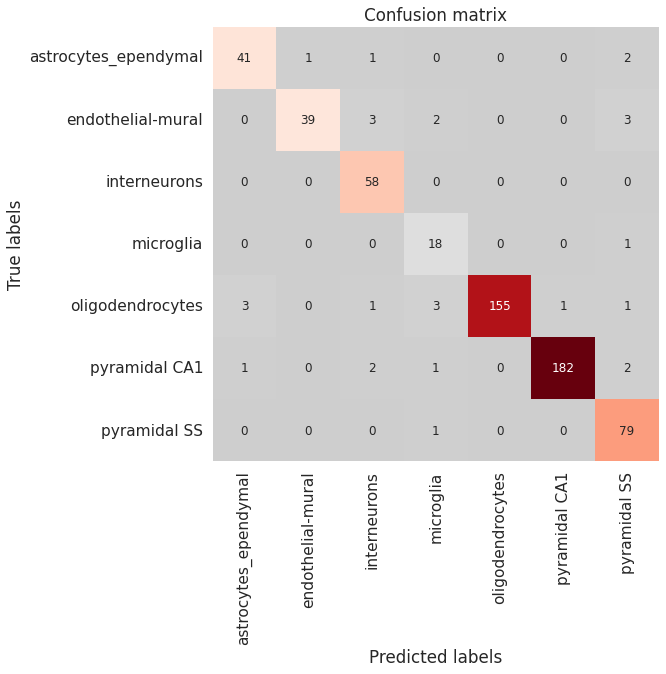

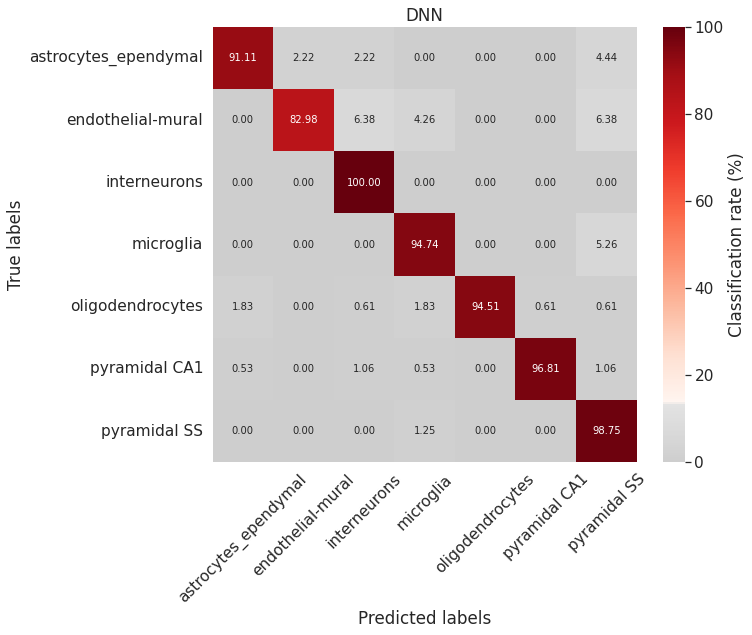

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


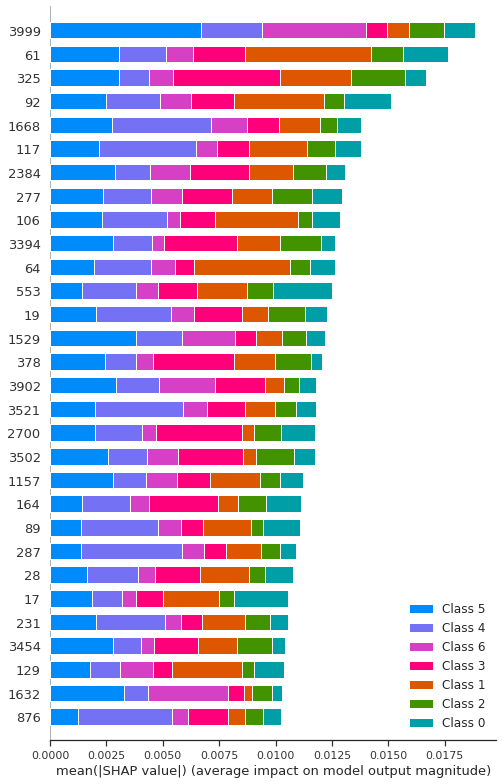

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                128032    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

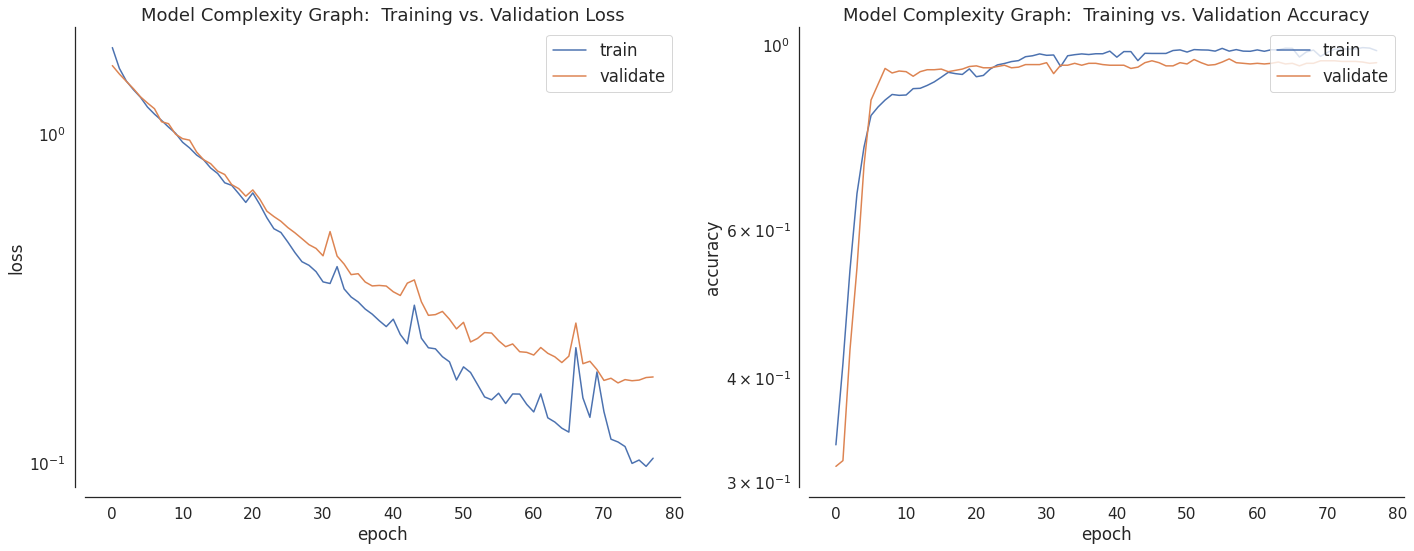

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

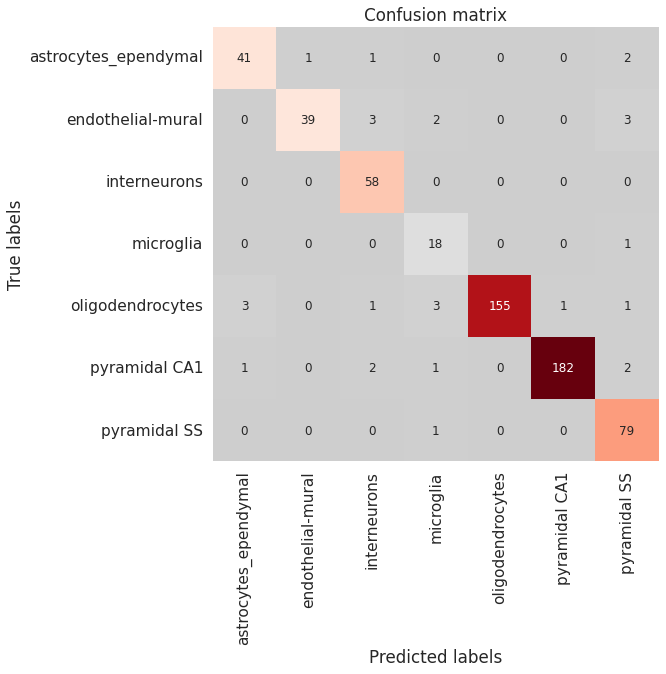

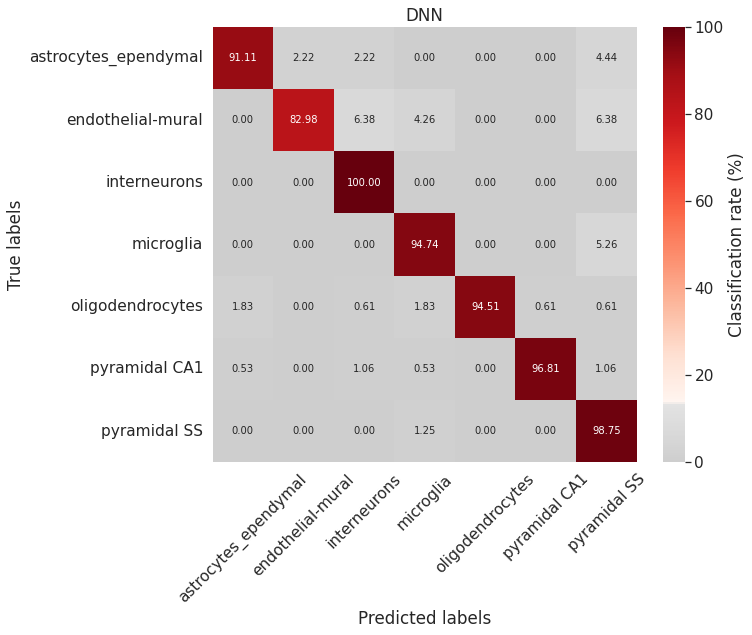

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


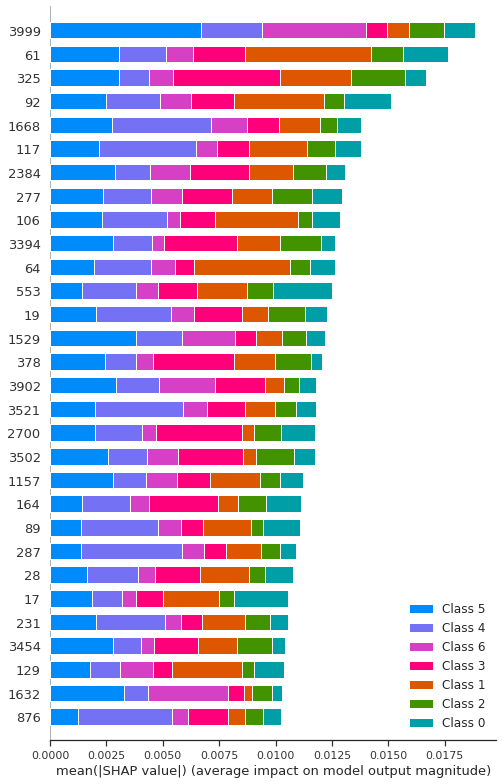

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

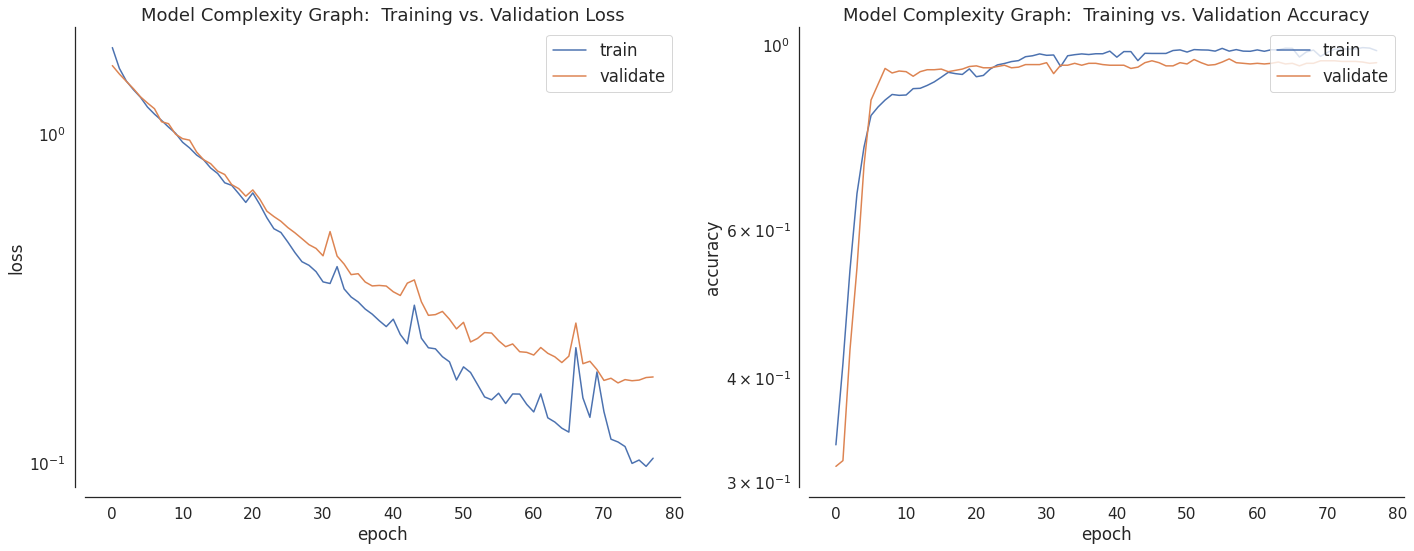

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

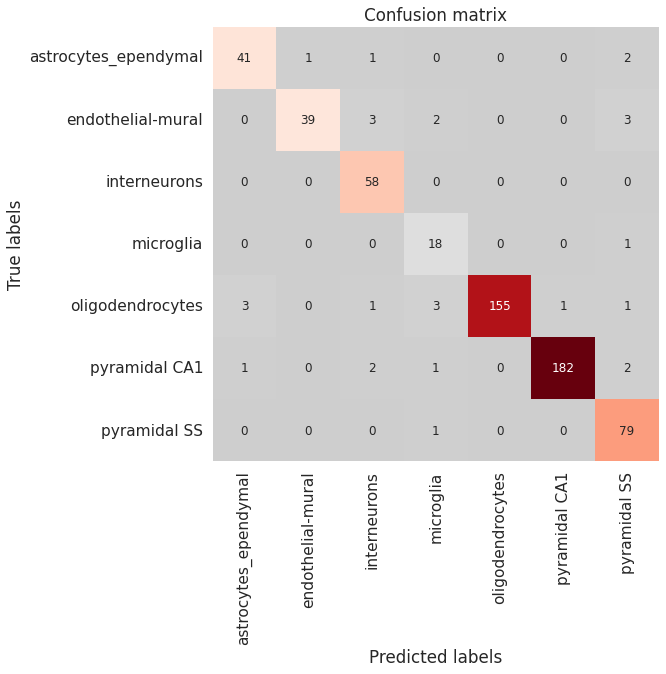

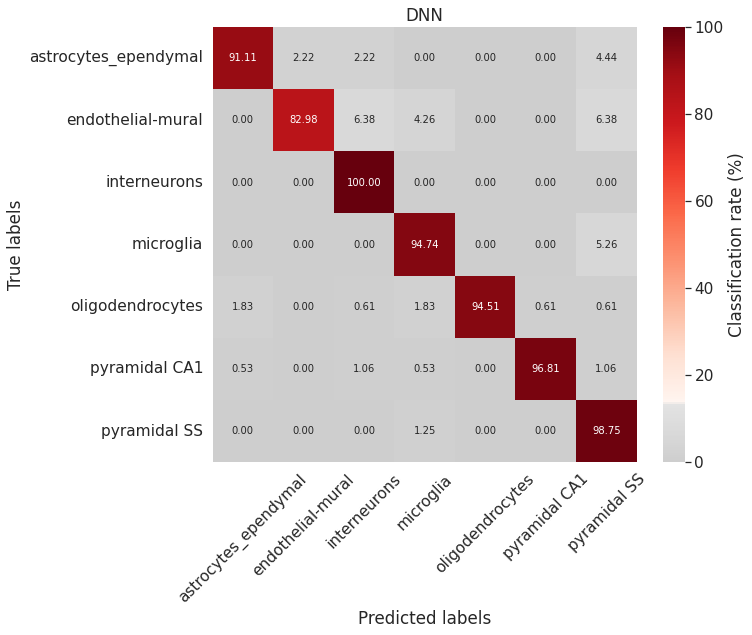

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


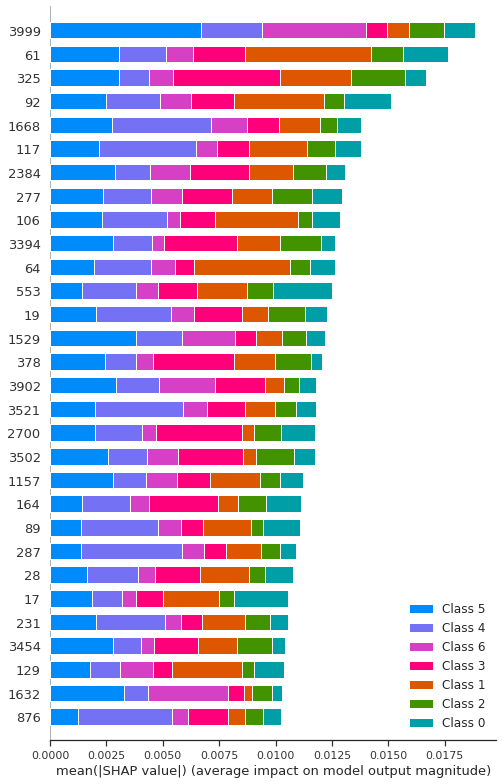

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

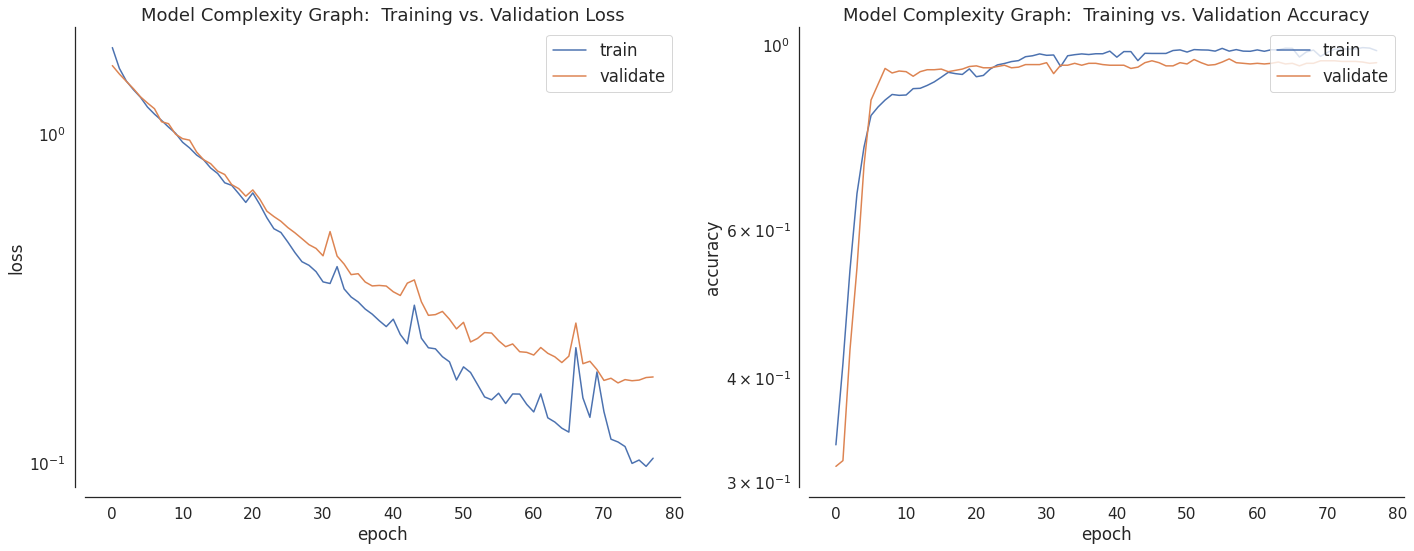

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

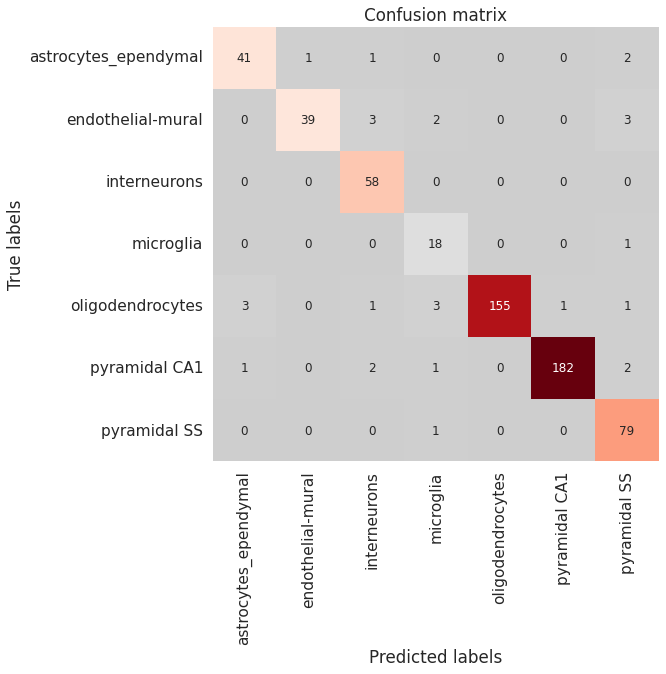

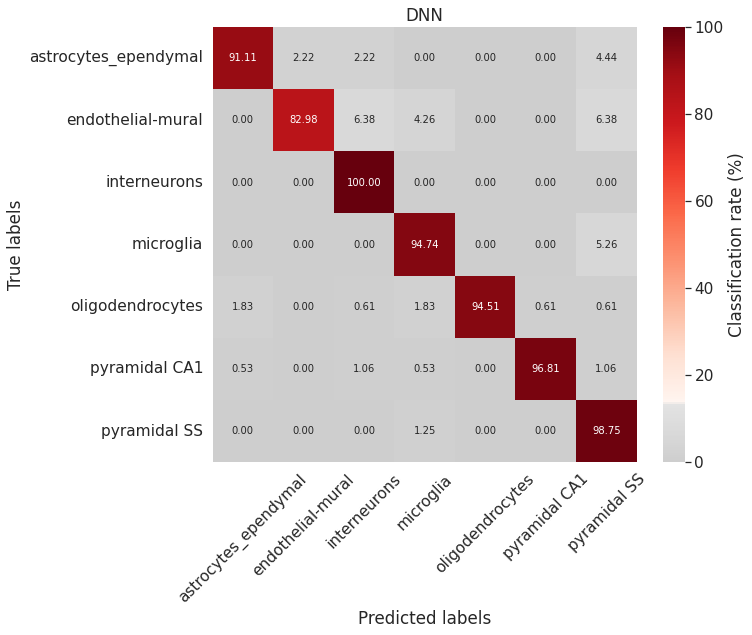

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


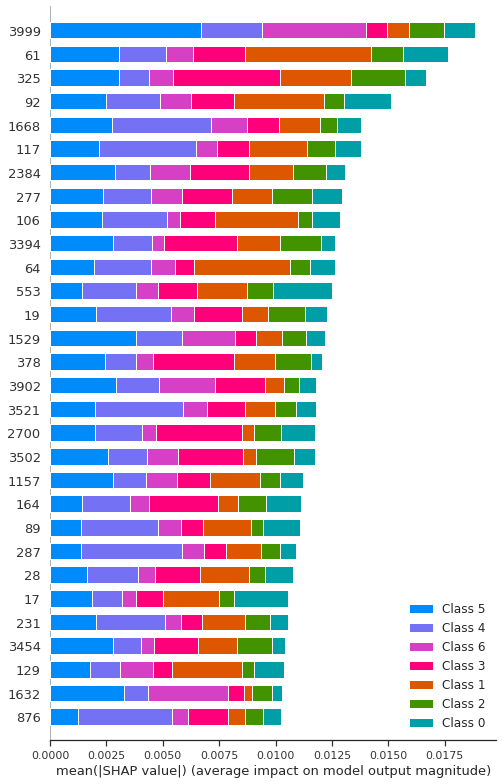

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

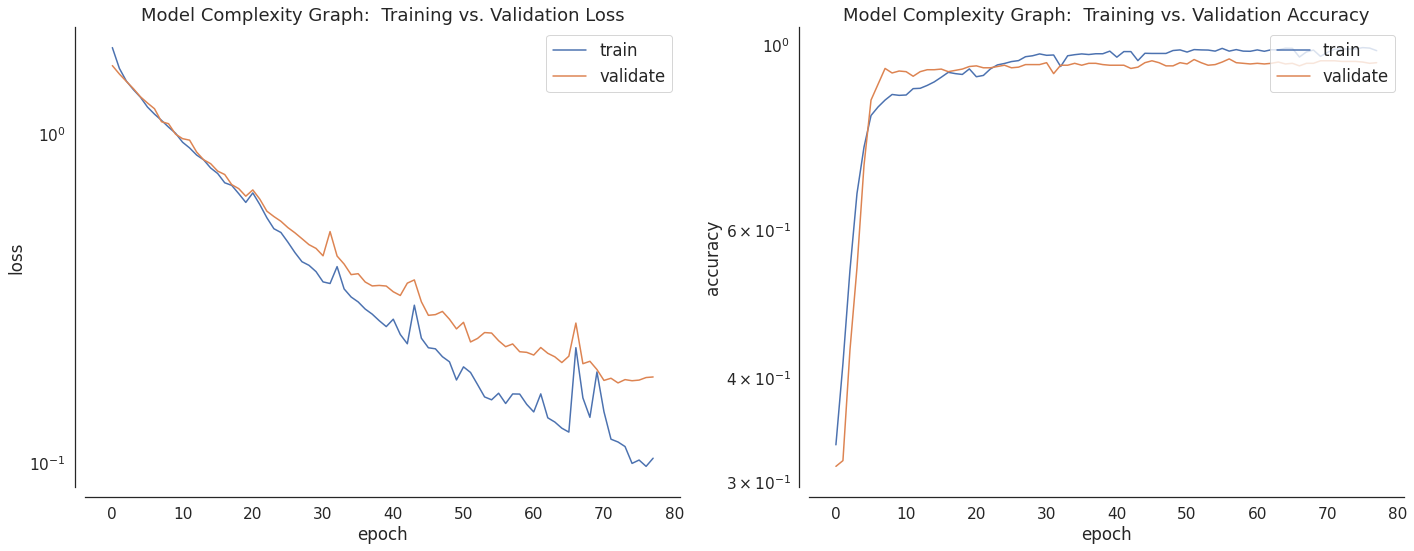

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

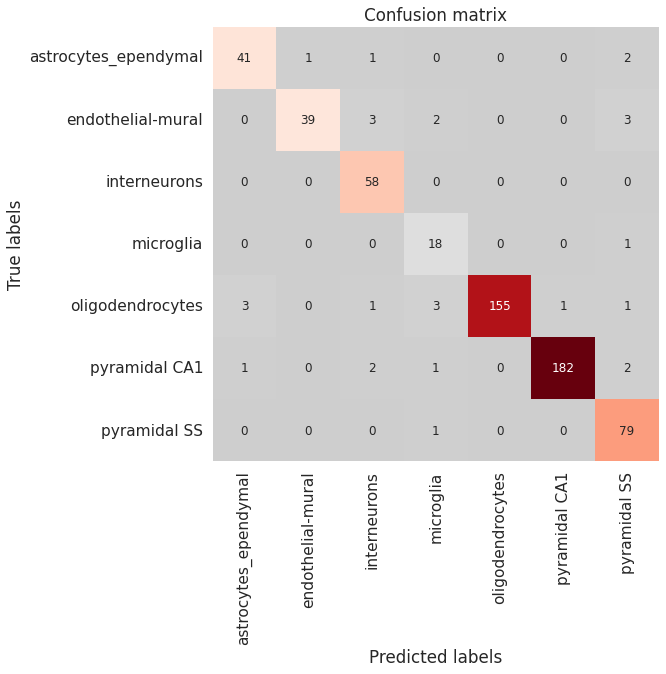

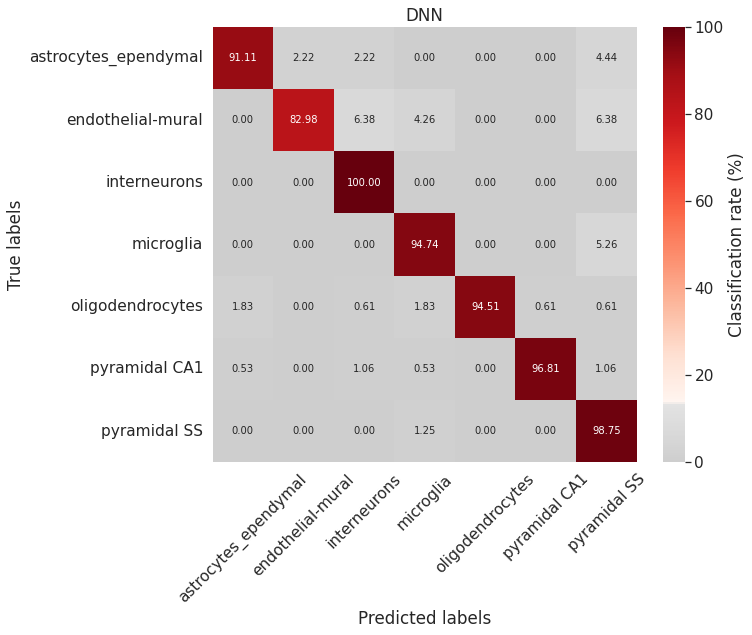

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


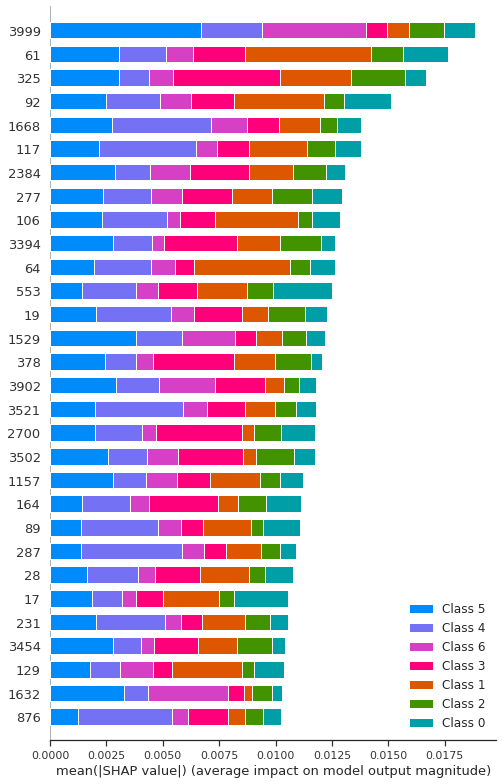

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

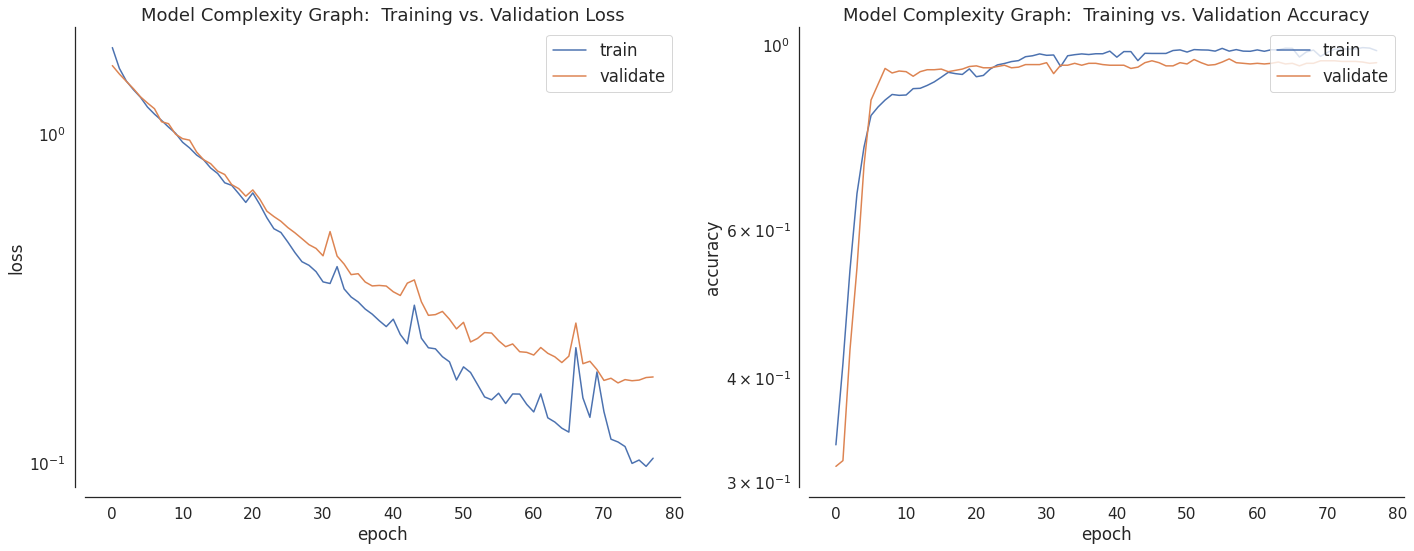

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

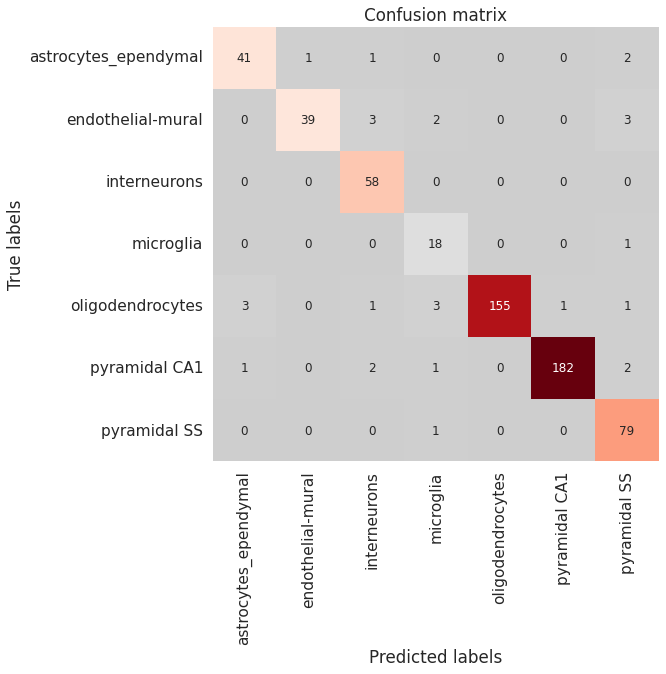

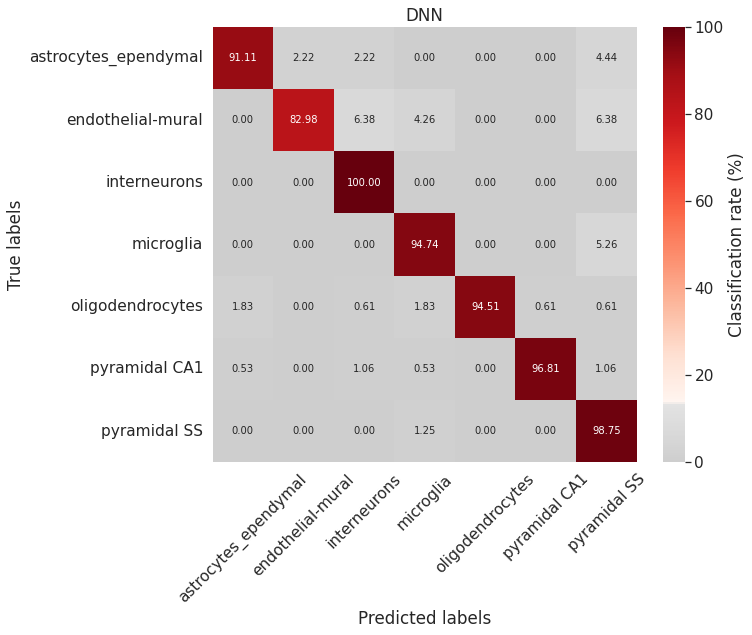

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


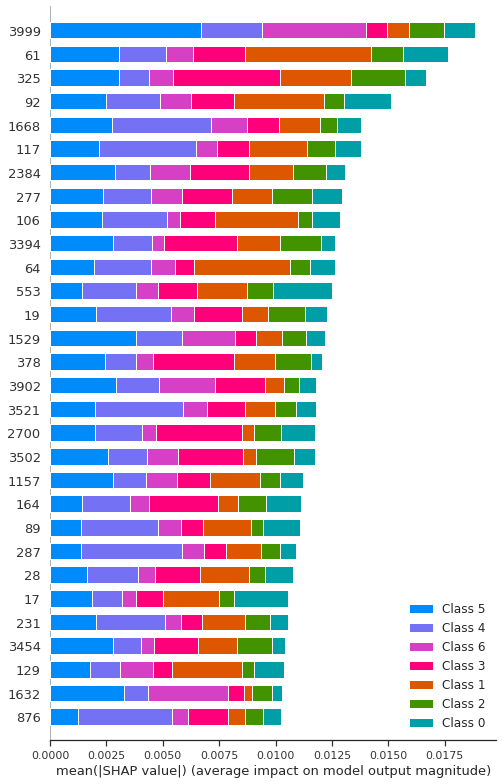

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

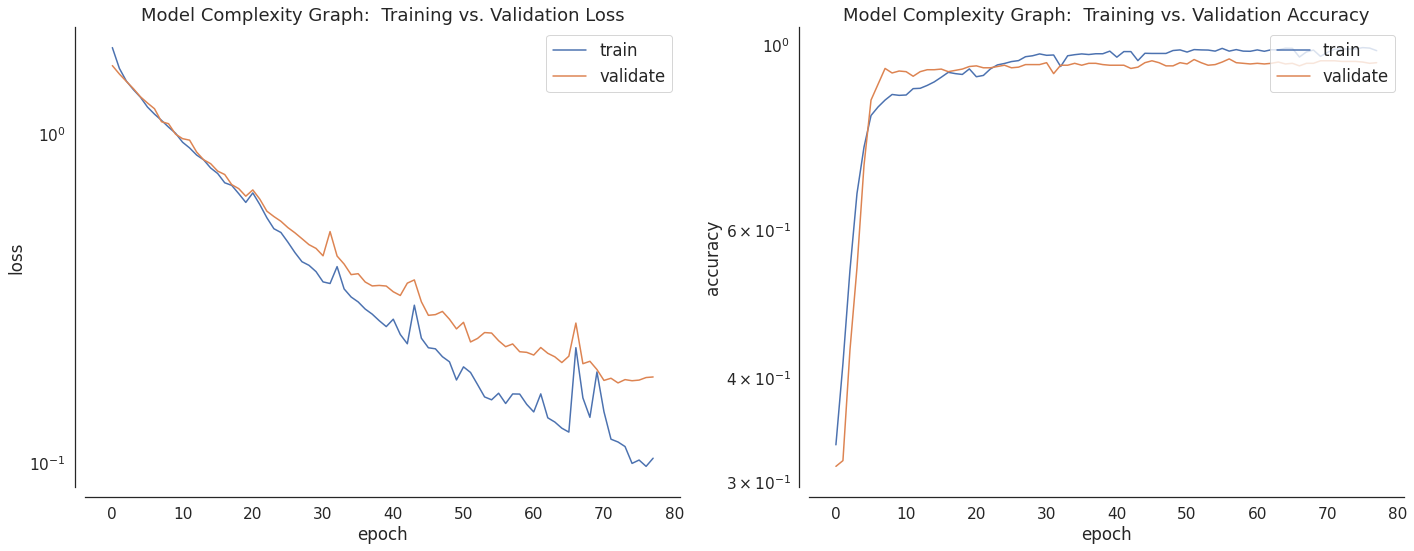

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

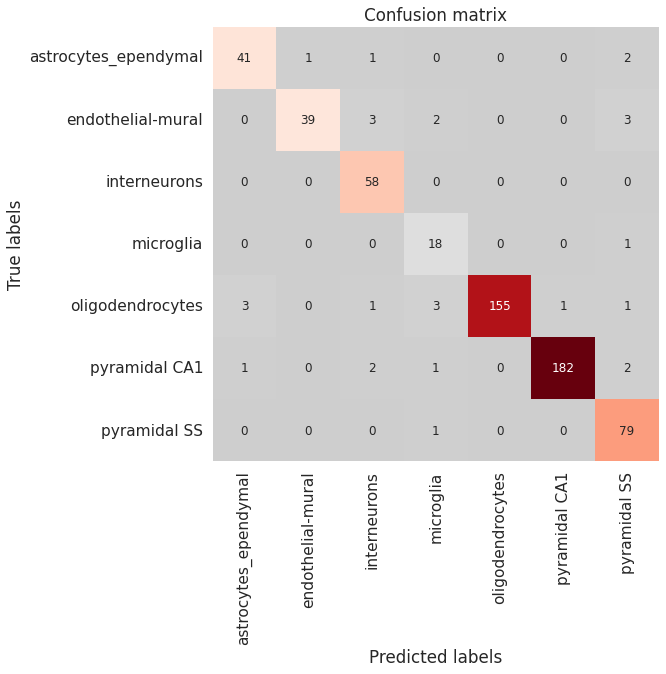

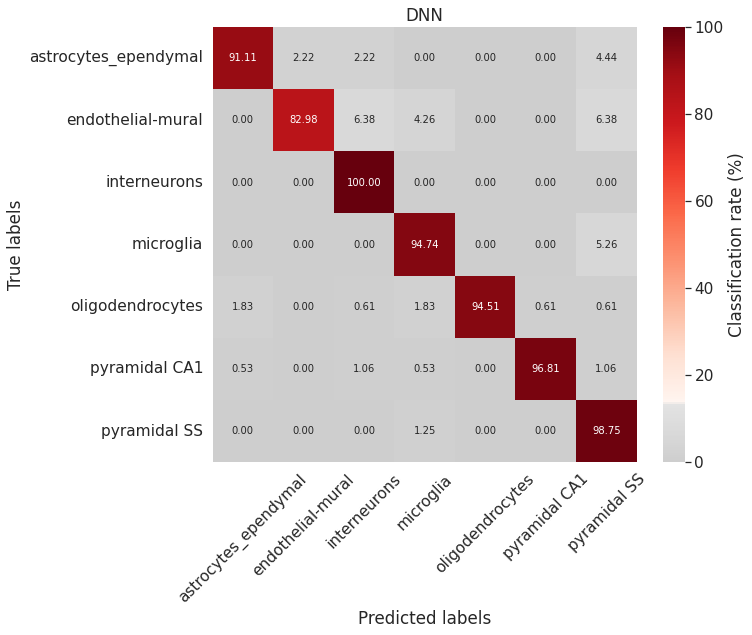

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


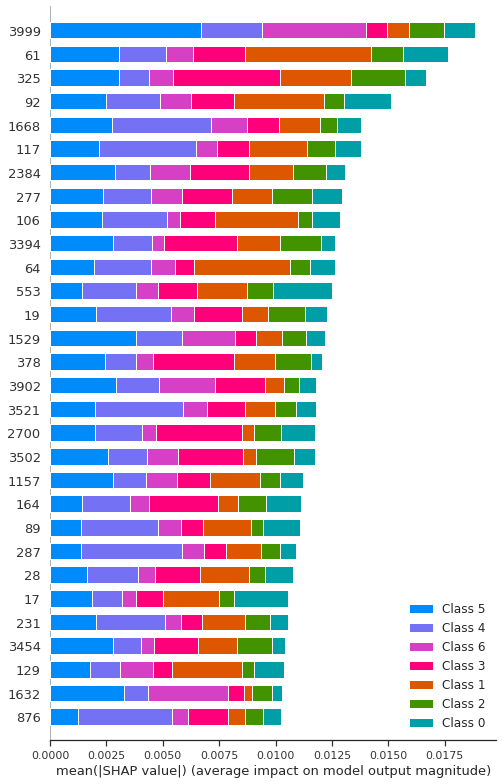

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

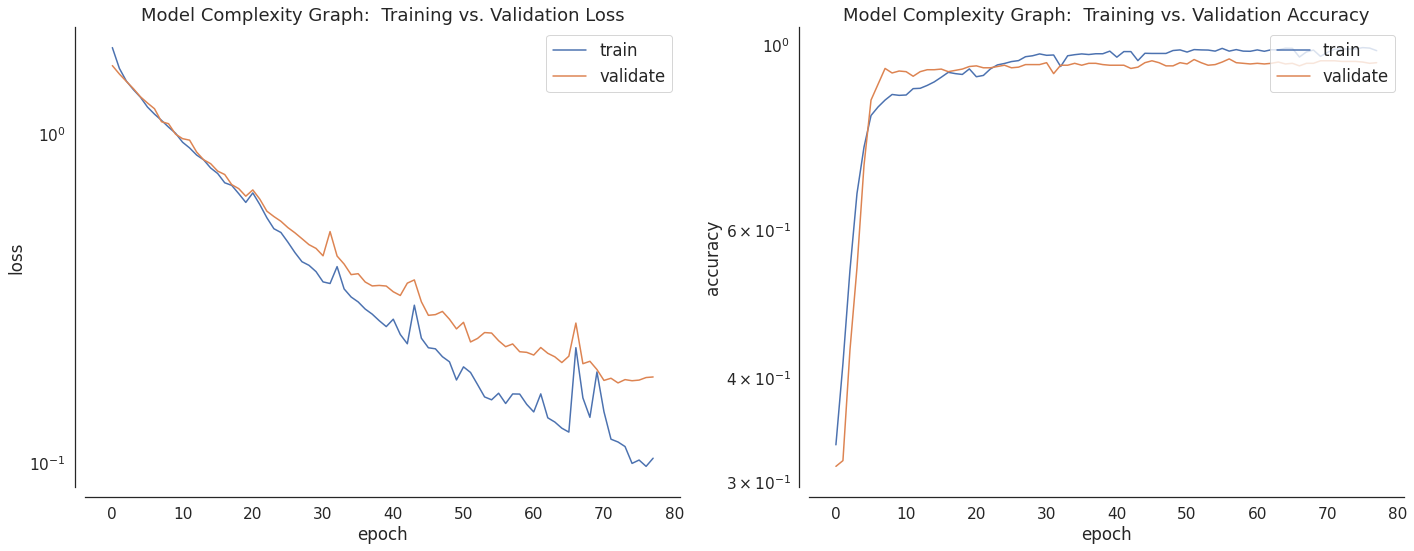

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

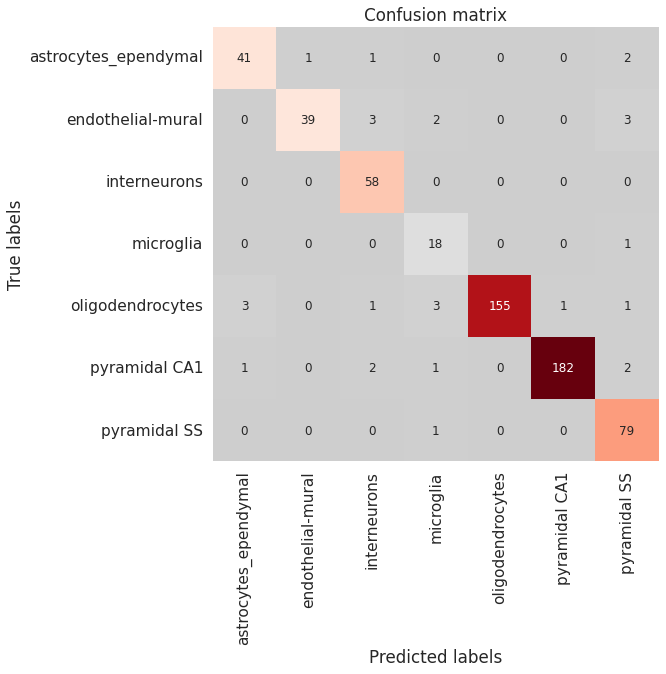

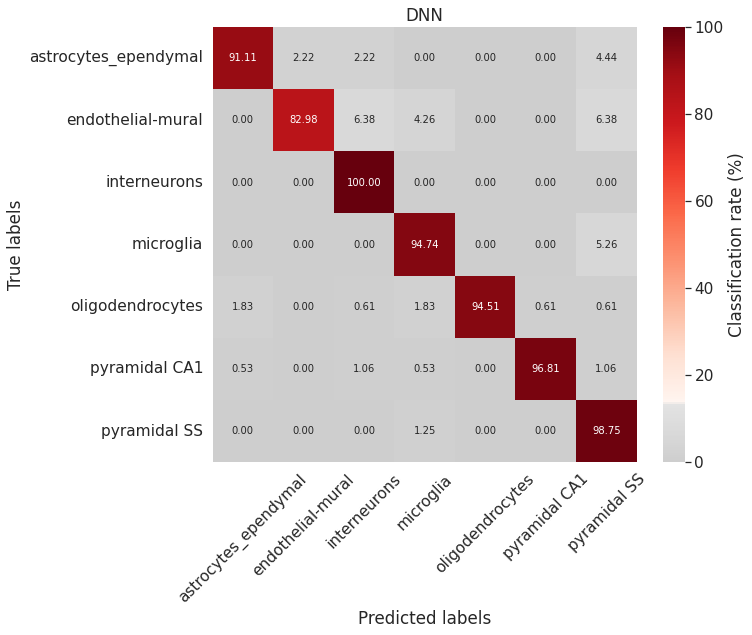

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


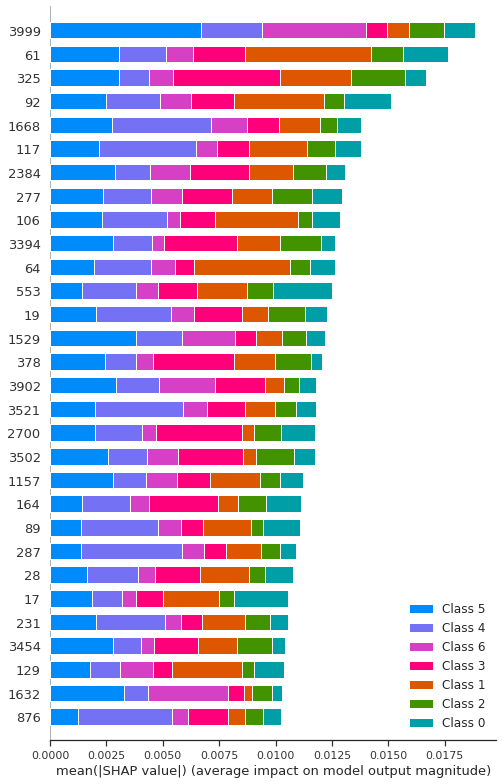

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

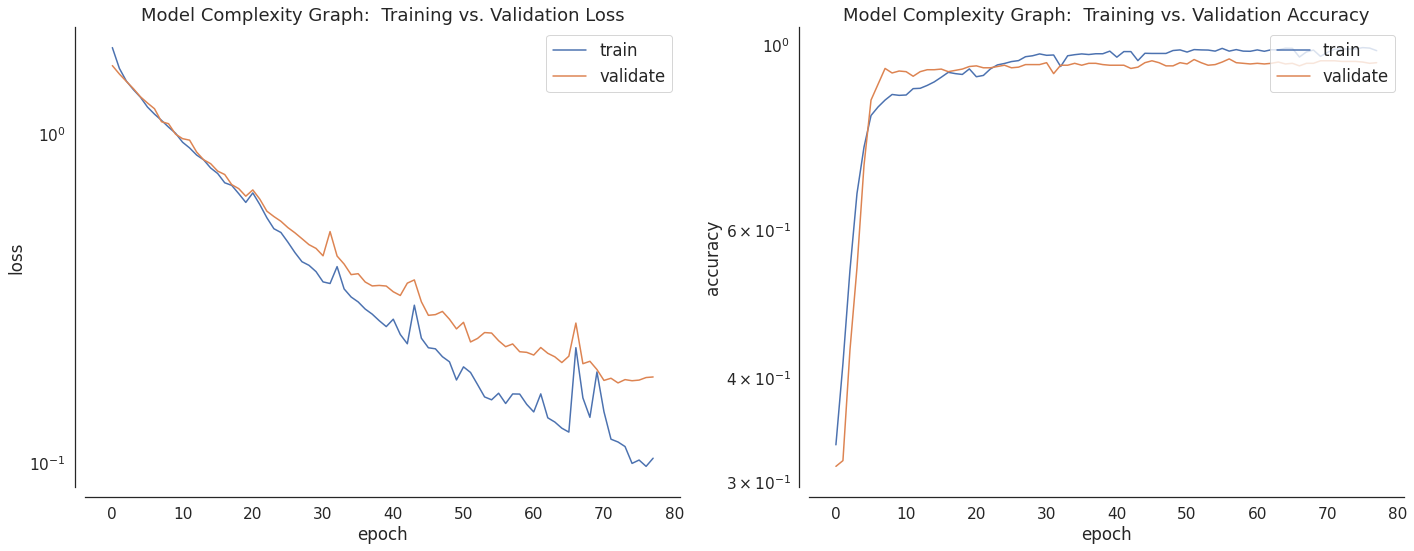

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

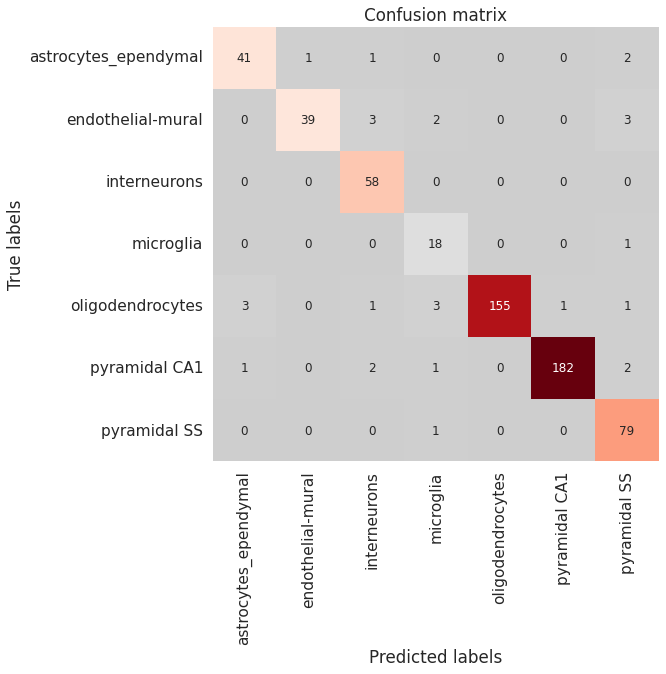

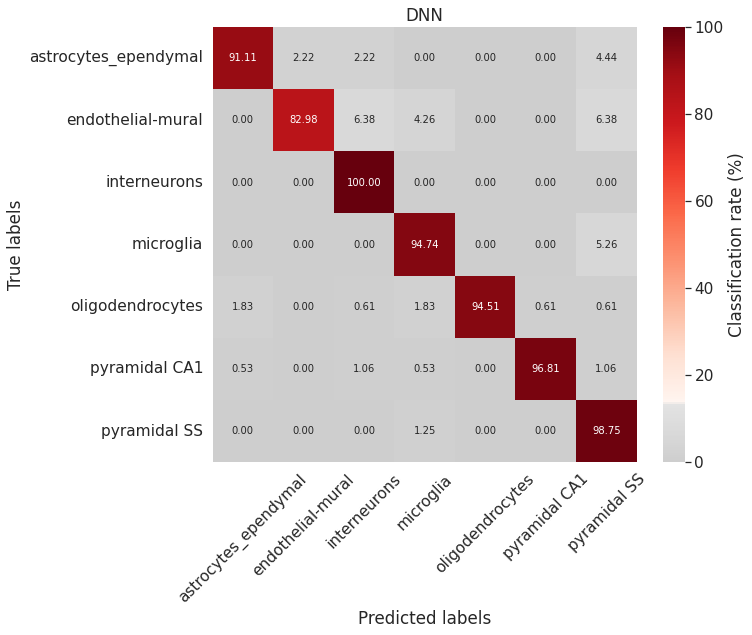

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


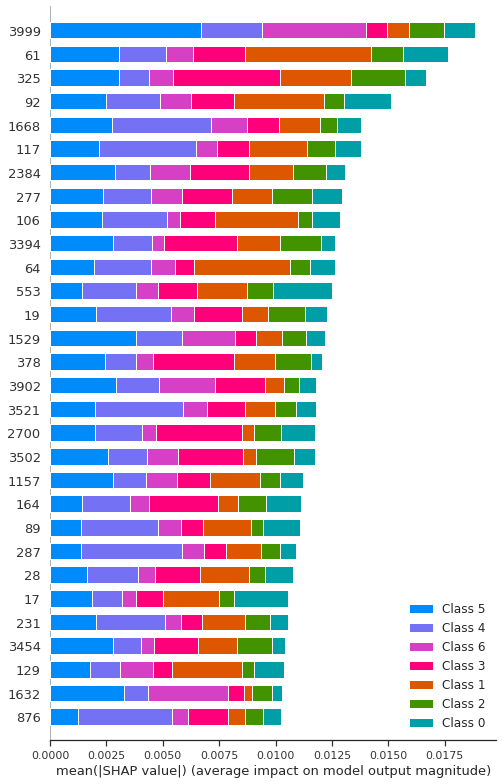

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

25/25 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not improve from 0.32221
Epoch 44/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9572 - auc: 0.9985 - precision: 0.9879 - recall: 0.8831 - val_loss: 0.3593 - val_accuracy: 0.9401 - val_auc: 0.9955 - val_precision: 0.9726 - val_recall: 0.8869

Epoch 00044: val_loss did not improve from 0.32221
Epoch 45/100
25/25 [===============


Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_loss improved from 0.20130 to 0.19968, saving model to weights/best_model_annotation.h5
Epoch 69/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9854 - auc: 0.9996 - precision: 0.9953 - recall: 0.9655 - val_loss: 0.2031 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9689 - val_recall: 0.9318

Epoch 00069: val_loss

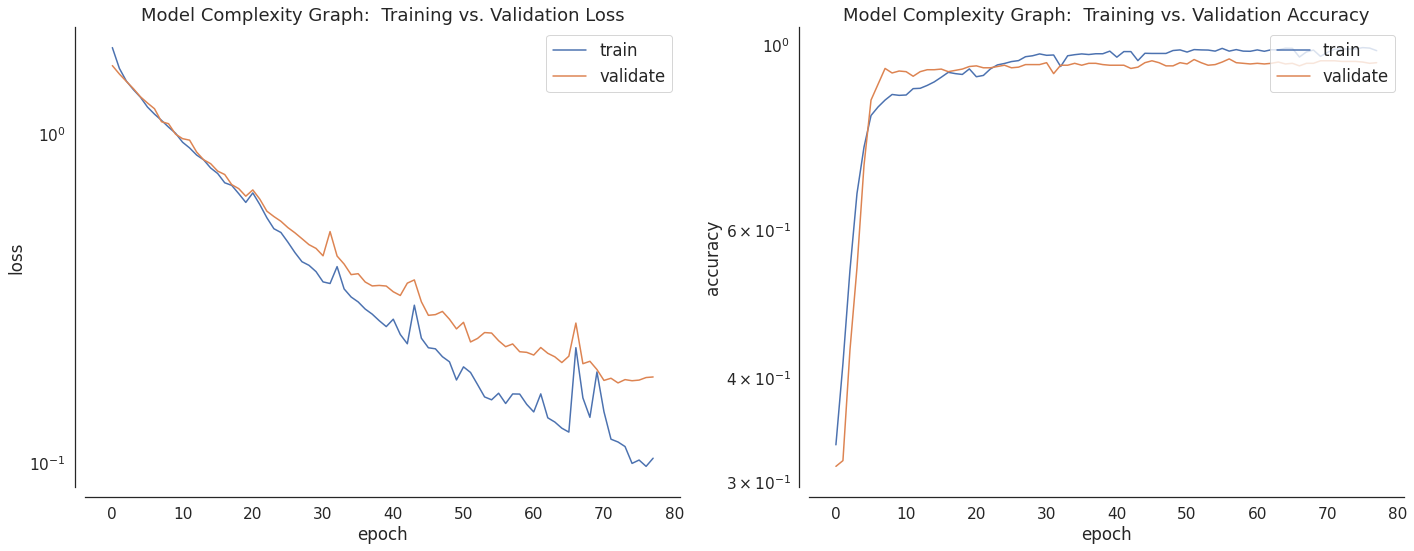

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

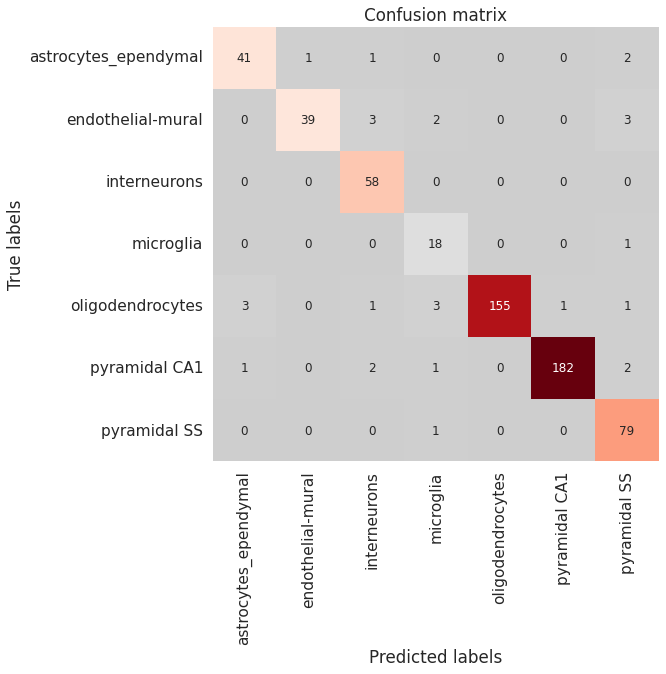

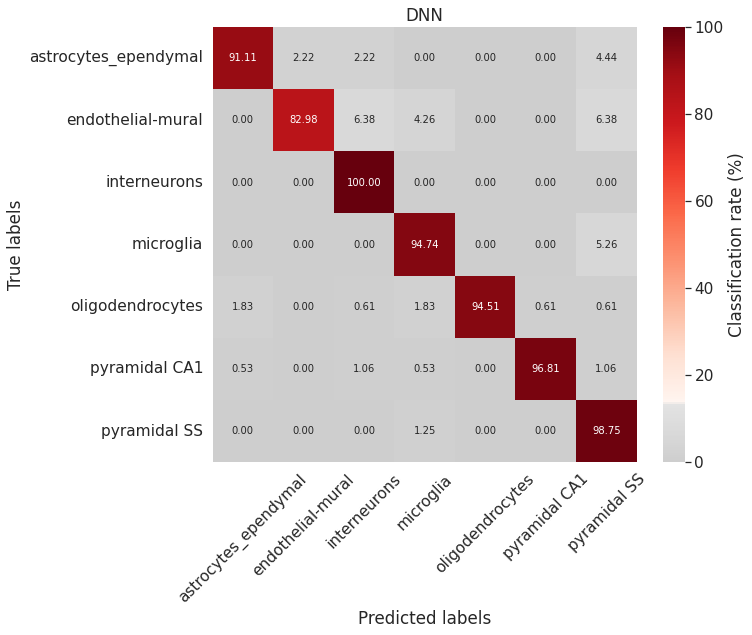

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601

19/19 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9551 - auc: 0.9973 - precision: 0.9658 - recall: 0.9384


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


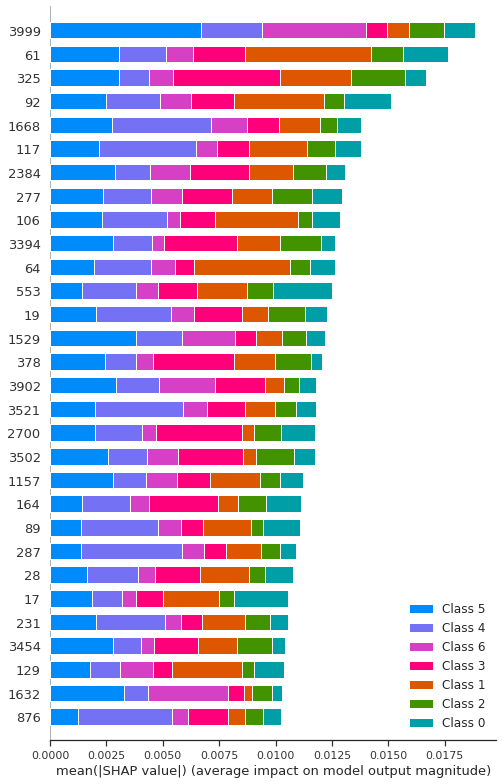

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 7min 8s, sys: 19.4 s, total: 7min 27s
Wall time: 4min 51s


In [19]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

## Train RankCorr

In [20]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

Excess Length of markers
52


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
54


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
57


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
53


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
52


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
55


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
54


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
53


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
53


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
55


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Train L1 VAE

In [16]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 50.02it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 49.67it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train Global Gate

In [17]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train MarkerMap Unsupervised

In [18]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train MarkerMap Supervised

In [19]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.16it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## MakerMap Mixed

In [20]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 26.31it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Concrete VAE

In [21]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 40.39it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.42it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## LassoNet



In [22]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
from functools import partial
from lassonet import plot_path

In [24]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier()
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

## Get Model Metrics from KNNs Classifiers

The above just generates metrics for the Random Forests.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [27]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [28]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [29]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [30]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

# Results and Visualizations

## Accuracies and F1

In [31]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [32]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [33]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.042429          0.956518   
L1 VAE                                     0.191514          0.794085   
Smash RF                                   0.054077          0.945045   
SMaSH DNN                                  0.069884          0.928087   
RankCorr                                   0.049584          0.949743   
Global Gate VAE                            0.187354          0.801429   
MarkerMap Unsupervised                     0.124126          0.867767   
MarkerMap Supervised                       0.044592          0.954919   
MarkerMap Mixed Supervision                0.066057          0.930760   
Concrete VAE                               0.200333          0.785367   
LassoNet                                   0.053577          0.945425   

                             Misclassification Standard Deviation  \
All Markers                                              0.006990   
L1 VAE                                                   0.035410   
Smash RF                                                 0.002496   
SMaSH DNN                                                0.000000   
RankCorr                                                 0.009465   
Global Gate VAE                                          0.045678   
MarkerMap Unsupervised                                   0.048105   
MarkerMap Supervised                                     0.006261   
MarkerMap Mixed Supervision                              0.010785   
Concrete VAE                                             0.044231   
LassoNet                                                 0.009553   

                             Weighted F1 Standard Deviation  
All Markers                                    7.214135e-03  
L1 VAE                                         4.028039e-02  
Smash RF                                       2.588877e-03  
SMaSH DNN                                      1.110223e-16  
RankCorr                                       9.624898e-03  
Global Gate VAE                                4.928572e-02  
MarkerMap Unsupervised                         5.401824e-02  
MarkerMap Supervised                           6.478326e-03  
MarkerMap Mixed Supervision                    1.218631e-02  
Concrete VAE                                   5.143222e-02  
LassoNet                                       9.544865e-03

In [34]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [35]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.053910          0.945497   
L1 VAE                                     0.260732          0.726230   
Smash RF                                   0.054243          0.945131   
SMaSH DNN                                  0.069884          0.928552   
RankCorr                                   0.054243          0.944592   
Global Gate VAE                            0.272712          0.716512   
MarkerMap Unsupervised                     0.153078          0.839899   
MarkerMap Supervised                       0.038436          0.961298   
MarkerMap Mixed Supervision                0.067055          0.930311   
Concrete VAE                               0.286023          0.699779   
LassoNet                                   0.059068          0.938102   

                             Misclassification Standard Deviation  \
All Markers                                              0.008259   
L1 VAE                                                   0.035132   
Smash RF                                                 0.001997   
SMaSH DNN                                                0.000000   
RankCorr                                                 0.009270   
Global Gate VAE                                          0.056098   
MarkerMap Unsupervised                                   0.049639   
MarkerMap Supervised                                     0.004554   
MarkerMap Mixed Supervision                              0.011977   
Concrete VAE                                             0.044264   
LassoNet                                                 0.010073   

                             Weighted F1 Standard Deviation  
All Markers                                    8.494210e-03  
L1 VAE                                         3.641567e-02  
Smash RF                                       2.073403e-03  
SMaSH DNN                                      2.220446e-16  
RankCorr                                       9.687345e-03  
Global Gate VAE                                6.125796e-02  
MarkerMap Unsupervised                         5.202864e-02  
MarkerMap Supervised                           4.651296e-03  
MarkerMap Mixed Supervision                    1.263149e-02  
Concrete VAE                                   4.957533e-02  
LassoNet                                       1.166241e-02

## Confusion Matrices

k = 50

### All Marker Baseline

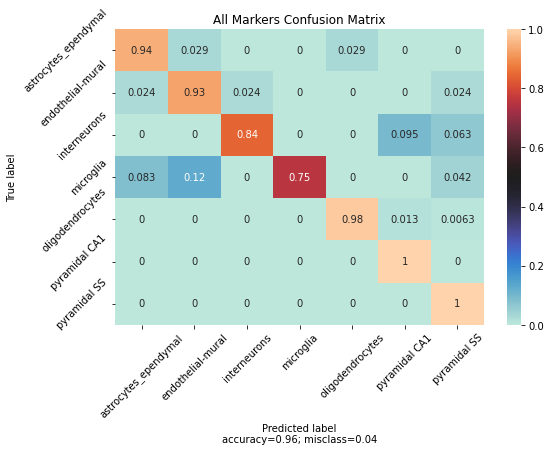

In [36]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [37]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

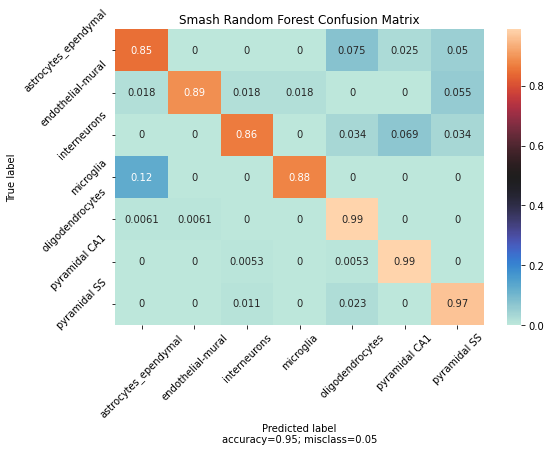

In [38]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

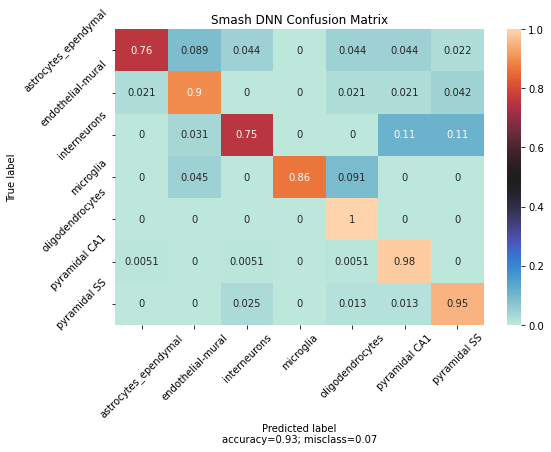

In [39]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

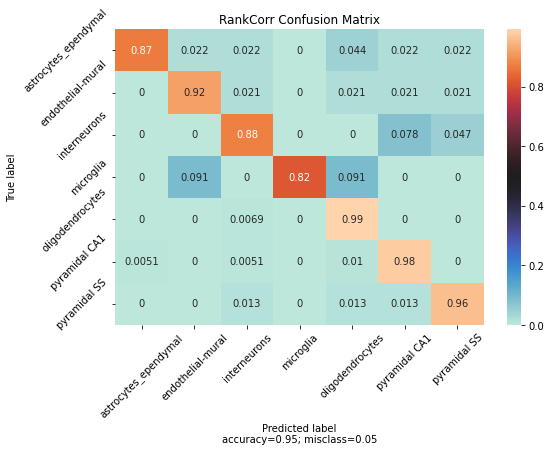

In [40]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

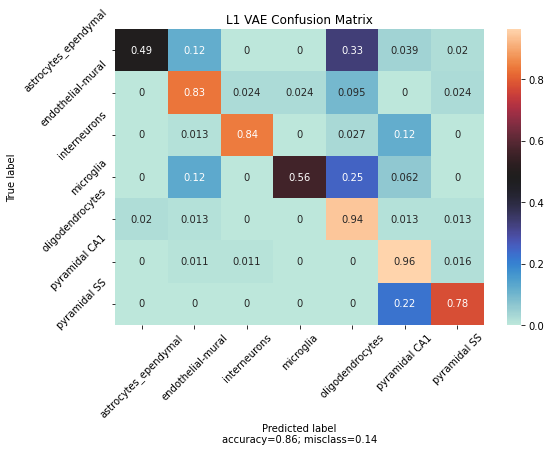

In [41]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

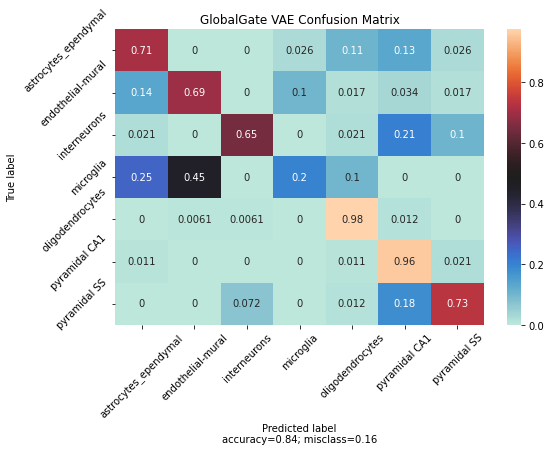

In [42]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### MarkerMap Unsupervised

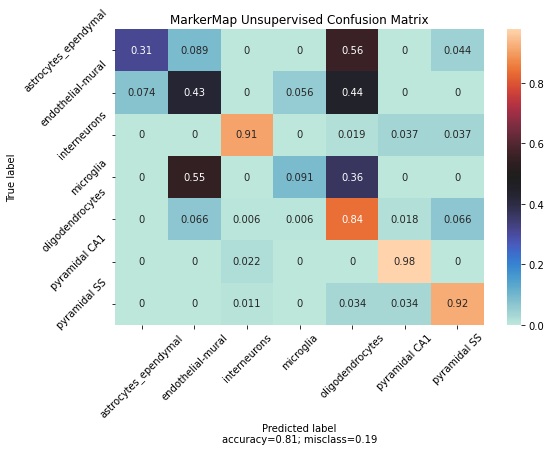

In [43]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


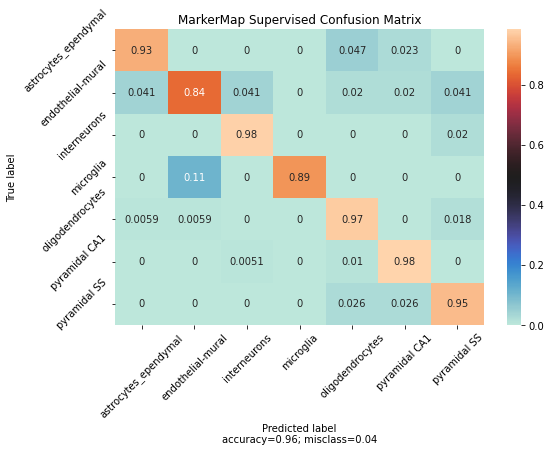

In [44]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

## MarkerMap Mixed Supervision

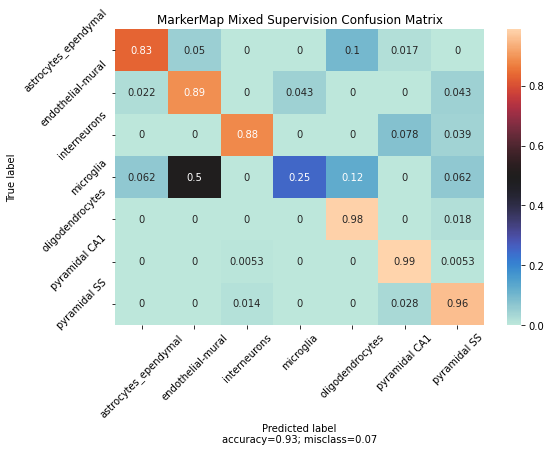

In [45]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

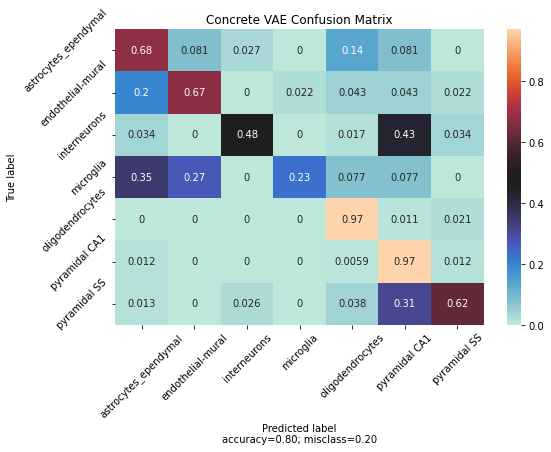

In [46]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

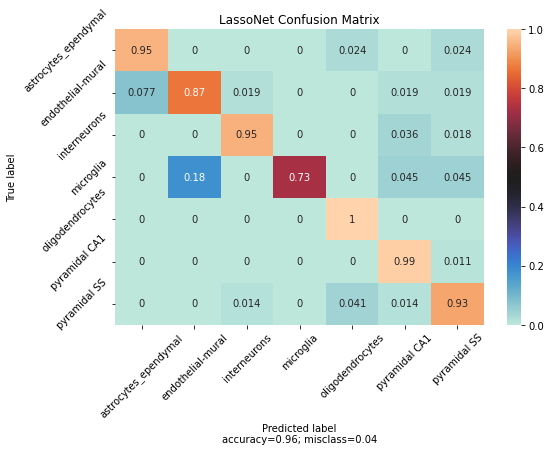

In [47]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')